# Part I: *Data Analysis and Preprocessing*

## 0. Import Packages

In [20]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import zscore
from netCDF4 import Dataset
import xarray as xr
import rioxarray
import os, io
from tqdm import tqdm

## A. Data Manipulation

#### a. Import, visualize, and save the contents of a dataset.

##### *algerian soil props*

In [2]:
# import and save
df_soil_dz_props = pd.read_csv('../Data/soil_dz_allprops.csv')

# visualize
df_soil_dz_props.head()

,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,...,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil,geometry
0,49.57,43.09,28.200,24.200,22.230,32.710,5.86,5.39,2.4110,0.7420,...,12.420,21.50,35.8,0.030,0.090,1.78,1.78,20.8,12.1,"POLYGON ((5.488269805908203 36.69034957885742,..."
1,56.97,55.06,21.440,19.190,21.690,25.680,5.92,6.02,1.0460,0.5500,...,17.380,66.50,61.4,0.760,0.830,1.19,1.32,9.7,8.0,"POLYGON ((7.277111053466797 37.02900695800781,..."
2,57.39,55.21,24.315,22.825,18.295,21.965,6.27,5.75,1.2295,0.3905,...,8.325,20.45,26.1,0.035,0.035,1.69,1.69,18.7,13.0,POLYGON ((7.367879867553711 36.955509185791016...
3,20.41,24.08,32.930,29.190,46.620,46.690,7.86,8.03,0.6790,0.3820,...,37.910,74.20,71.0,6.330,6.770,1.54,1.58,9.3,9.6,"POLYGON ((7.681180000305176 36.97943878173828,..."
4,31.42,28.46,21.650,20.520,46.890,50.950,7.32,7.49,0.6190,0.4240,...,36.980,72.10,69.8,1.950,2.720,1.54,1.67,9.0,8.7,"POLYGON ((8.664039611816406 36.89445877075195,..."


##### *algerian polygon*

                                            geometry
0  POLYGON ((-4.82161 24.99506, -4.99519 25.10209...
Axes(0.222002,0.11;0.580997x0.77)


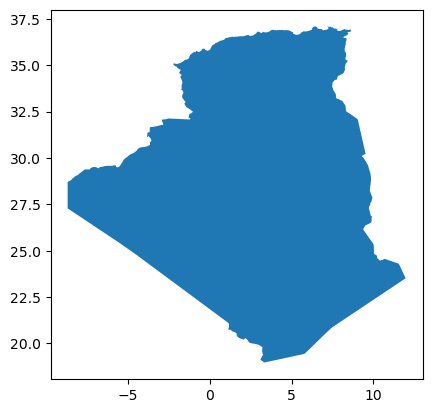

In [3]:
# import and save
gdf_dz_poly = gpd.read_file(filename='../Data/dz_shp/dz.shp')
gdf_dz_poly = gdf_dz_poly.drop(['id', 'name', 'source'], axis=1)

# visualize
print(gdf_dz_poly.head())
print(gdf_dz_poly.plot())

# save the polygon of Algeria
polygon_dz = gdf_dz_poly['geometry'].iloc[0]

##### *change type of geometry to polygon objects*

In [4]:
def safe_wkt_loads(wkt_str):
    try:
        return wkt.loads(wkt_str)
    except Exception as e:
        print(f"Error parsing WKT: {wkt_str} -> {e}")
        return None  # Return None for entries that fail

df_soil_dz_props['geometry'] = df_soil_dz_props['geometry'].apply(safe_wkt_loads)


df_soil_dz_props.dropna(subset=['geometry'], how='all', inplace=True)

In [5]:
df_soil_dz_props = df_soil_dz_props[df_soil_dz_props['geometry'].apply(lambda x: polygon_dz.intersects(x))]
df_soil_dz_props.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 0 to 294
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sand % topsoil    286 non-null    float64
 1   sand % subsoil    286 non-null    float64
 2   silt % topsoil    286 non-null    float64
 3   silt% subsoil     286 non-null    float64
 4   clay % topsoil    286 non-null    float64
 5   clay % subsoil    286 non-null    float64
 6   pH water topsoil  286 non-null    float64
 7   pH water subsoil  286 non-null    float64
 8   OC % topsoil      286 non-null    float64
 9   OC % subsoil      286 non-null    float64
 10  N % topsoil       286 non-null    float64
 11  N % subsoil       286 non-null    float64
 12  BS % topsoil      286 non-null    float64
 13  BS % subsoil      286 non-null    float64
 14  CEC topsoil       286 non-null    float64
 15  CEC subsoil       286 non-null    float64
 16  CEC clay topsoil  286 non-null    float64
 17  CE

##### *plotting of dz regions plygons*

<Axes: >

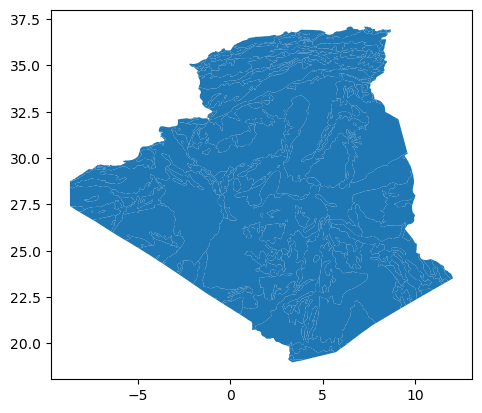

In [6]:
gdf_soil_dz_props = gpd.GeoDataFrame(df_soil_dz_props, geometry='geometry')
gdf_soil_dz_props.plot()

##### *plotting intersection between dz polygon and regions polygons*

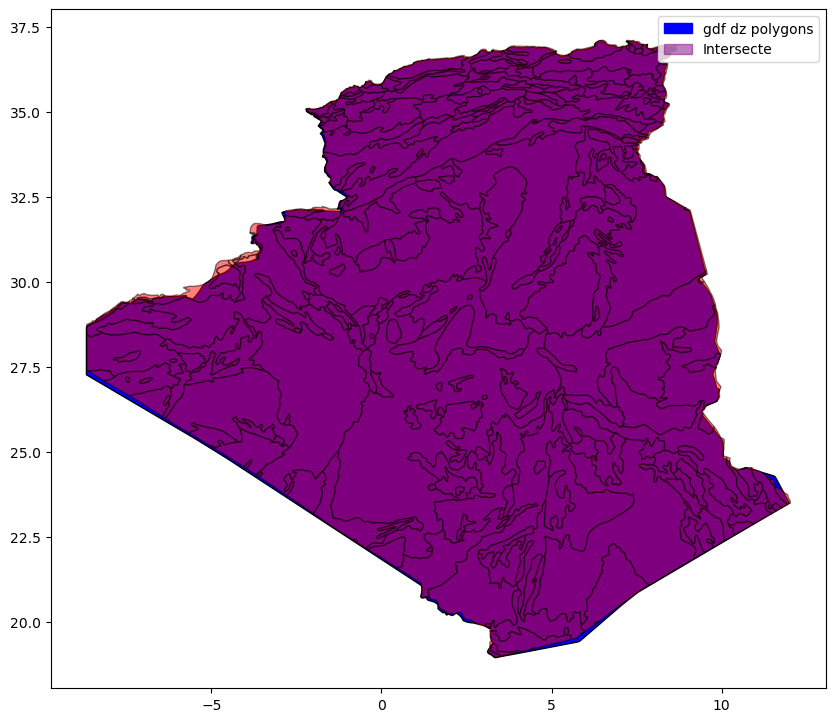

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_dz_poly.plot(ax=ax, color="blue", edgecolor="black", label="gdf dz polygons")

gdf_soil_dz_props.plot(ax=ax, color="red", edgecolor="black", alpha=0.5, label="Intersecte")

blue_patch = mpatches.Patch(color="blue", label="gdf dz polygons")
white_patch = mpatches.Patch(color="purple", alpha=0.5, label="Intersecte")

ax.legend(handles=[blue_patch, white_patch])

plt.show()

##### *Save new csv with regions intersects the algerian polygon*

In [8]:
gdf_soil_dz_props.to_csv('../Data/processedData/soil_dz.csv', index=False)

##### *Save new nc files specific just to the algeria's climate*

In [9]:
dz_bounds = polygon_dz.bounds

print(dz_bounds)

def dz_nc(input_file, output_file, dz_bounds):

    # Open the NetCDF file with xarray
    ds = xr.open_dataset(input_file)



    # Define longitude and latitude bounds
    
    lon_min, lon_max = dz_bounds[0], dz_bounds[2]
    lat_min, lat_max = dz_bounds[1], dz_bounds[3]
    
    ds_subset = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))


    ds_subset.to_netcdf(output_file)
    
    print(f" dataset saved to {output_file}")

input_folder = '../Data/Climate-DATA/'
output_folder = '../Data/processedData/climate-data/'

os.makedirs(output_folder, exist_ok=True)

for name_file in os.listdir(input_folder):
    input_file_path = os.path.join(input_folder, name_file)

    if os.path.isfile(input_file_path) and name_file.endswith('.nc'):
        new_name_file = f"dz_{name_file}"
        output_file_path = os.path.join(output_folder, new_name_file)

        dz_nc(input_file_path, output_file_path, dz_bounds)

(-8.68238521619834, 18.97556113605486, 11.968860720039096, 37.09393951787425)
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201901_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201902_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201903_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201904_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201905_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201906_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201907_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201908_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201909_v2.1.nc
 dataset saved to ../Data/processedData/climate-data/dz_PSurf_WFDE5_CRU_201910_v2.1.nc
 dataset saved to ../Data/processedData/climate-data

##### *Aggregate by seasons*

In [ ]:
def calculate_matrix_avg(input_files):
    matrix_avg_list = []
    lat = lon = None  # Initialize lat and lon to capture coordinates

    # for input_file in input_files:
    for input_file in tqdm(input_files, desc="Files", position=0):
        ds = xr.open_dataset(input_file)

        # Capture latitude and longitude coordinates from the dataset
        if lat is None or lon is None:
            lat = ds.coords['lat']
            lon = ds.coords['lon']

        matrix_list = []
        for i, t in enumerate(ds.time):
            # Selecting only the data variable without stacking
            single_time_ds = ds.sel(time=t)
            matrix_np = single_time_ds.to_array().isel(variable=0).values  # Selecting the first variable explicitly
            matrix_list.append(matrix_np)

        stacked_matrices = np.stack(matrix_list, axis=0)
        average_matrix = np.mean(stacked_matrices, axis=0)
        matrix_avg_list.append(average_matrix)

    stacked_avg_matrices = np.stack(matrix_avg_list, axis=0)
    avg_matrices = np.mean(stacked_avg_matrices, axis=0)

    # Create an xarray DataArray to include lat/lon coordinates
    avg_matrix_da = xr.DataArray(
        avg_matrices,
        coords={'lat': lat, 'lon': lon},
        dims=['lat', 'lon']
    )
    return avg_matrix_da


def season_matrices_avg(input_folder, output_folder, season, metric):
    input_files = []
    if season.lower() == 'winter':
        # print('winter')
        for name_file in os.listdir(input_folder):
            input_file_path = os.path.join(input_folder, name_file)
            if metric.lower() in name_file.lower() and ('201912' in input_file_path or '201901' in input_file_path or '201902' in input_file_path):
                input_files.append(input_file_path)
    elif season.lower() == 'autumn':
        # print('autumn')
        for name_file in os.listdir(input_folder):
            input_file_path = os.path.join(input_folder, name_file)
            if metric.lower() in name_file.lower() and ('201911' in input_file_path or '201910' in input_file_path or '201909' in input_file_path):
                input_files.append(input_file_path)
    elif season.lower() == 'spring':
        # print('spring')
        for name_file in os.listdir(input_folder):
            input_file_path = os.path.join(input_folder, name_file)
            if metric.lower() in name_file.lower() and ('201903' in input_file_path or '201904' in input_file_path or '201905' in input_file_path):
                input_files.append(input_file_path)
    elif season.lower() == 'summer':
        # print('summer')
        for name_file in os.listdir(input_folder):
            input_file_path = os.path.join(input_folder, name_file)
            if metric.lower() in name_file.lower() and ('201908' in input_file_path or '201907' in input_file_path or '201906' in input_file_path):
                input_files.append(input_file_path)
    else:
        print('invalid season')

    avg_matrix_da = calculate_matrix_avg(input_files)
    new_name_file = f"dz_{metric}_{season}.nc"
    output_file_path = os.path.join(output_folder, new_name_file)

    # Save the DataArray as a NetCDF file, preserving lat/lon coordinates
    avg_matrix_da.to_netcdf(output_file_path)

In [22]:
seasons = ['autumn', 'winter', 'spring', 'summer']
metrics = ['PSurf', 'Qair', 'Rainf',  'Snowf', 'Tair', 'Wind']

input_folder= '../Data/processedData/climate-data/'
output_folder= '../Data/processedData/climate-data/seasons/'
os.makedirs(output_folder, exist_ok=True)



for metric in tqdm(metrics, desc="Metrics", position=0):
    for season in tqdm(seasons, desc="Seasons", position=1, leave=False):
        season_matrices_avg(input_folder, output_folder, season, metric)

# for metric in metrics:
#     for season in seasons:
#         season_matrices_avg(input_folder, output_folder, season, metric)

Metrics: 100%|██████████| 6/6 [04:02<00:00, 40.50s/it]


In [23]:
df_soil_dz_props = pd.read_csv('../Data/processedData/soil_dz.csv')
df_soil_dz_props.to_csv('../Data/processedData/soil_dz_processed.csv', index=False)

In [24]:
def create_col(nc_file, csv_file):
    ds = xr.open_dataset(nc_file)
    df = pd.read_csv(csv_file)
    psurf_values = []
    for idx, row in df.iterrows():
        pol = wkt.loads(row['geometry'])
        bounds = pol.bounds
        lon_min, lat_min, lon_max, lat_max = bounds
    
    # Sélectionnez les données qui correspondent au polygone
        ds_sub = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    
    # Si des données sont trouvées, prenez la moyenne
        if len(ds_sub['__xarray_dataarray_variable__']) > 0:
            psurf = ds_sub['__xarray_dataarray_variable__'].mean().values
        else:
            psurf = float('nan')
    
        psurf_values.append(psurf)
    variable_name = os.path.basename(nc_file).split('.')[0].split('_', 1)[1]
    df[variable_name] = psurf_values
    return df

In [26]:
df_soil_dz_props = pd.read_csv('../Data/processedData/soil_dz_processed.csv')
df_soil_dz_props.to_csv('../Data/processedData/climate-data/seasons/soil_dz_processed.csv', index=False)
input_dir = '../Data/processedData/climate-data/seasons/'
nc_files = [f for f in os.listdir(input_dir) if f.endswith('.nc')]
print(nc_files)

# for f in nc_files:
for f in tqdm(nc_files, desc=f"Processing files", position=0):
    # print(f)
    nc_path = os.path.join(input_dir, f)
    df_soil_dz_props=create_col(nc_path, '../Data/processedData/climate-data/seasons/soil_dz_processed.csv')
    df_soil_dz_props.to_csv('../Data/processedData/climate-data/seasons/soil_dz_processed.csv', index=False)
df_soil_dz_props['Wind_winter'] = df_soil_dz_props['Wind_winter'].astype('float64')
df_soil_dz_props.to_csv('../Data/processedData/climate-data/seasons/soil_dz_processed.csv', index=False)
df_soil_dz_props

['dz_PSurf_autumn.nc', 'dz_PSurf_spring.nc', 'dz_PSurf_summer.nc', 'dz_PSurf_winter.nc', 'dz_Qair_autumn.nc', 'dz_Qair_spring.nc', 'dz_Qair_summer.nc', 'dz_Qair_winter.nc', 'dz_Rainf_autumn.nc', 'dz_Rainf_spring.nc', 'dz_Rainf_summer.nc', 'dz_Rainf_winter.nc', 'dz_Snowf_autumn.nc', 'dz_Snowf_spring.nc', 'dz_Snowf_summer.nc', 'dz_Snowf_winter.nc', 'dz_Tair_autumn.nc', 'dz_Tair_spring.nc', 'dz_Tair_summer.nc', 'dz_Tair_winter.nc', 'dz_Wind_autumn.nc', 'dz_Wind_spring.nc', 'dz_Wind_summer.nc', 'dz_Wind_winter.nc']


Processing files: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s]


,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,...,Snowf_summer,Snowf_winter,Tair_autumn,Tair_spring,Tair_summer,Tair_winter,Wind_autumn,Wind_spring,Wind_summer,Wind_winter
0,49.570,43.090,28.200,24.200,22.230,32.710,5.860,5.390,2.4110,0.7420,...,0.0,5.143899e-07,290.56107,286.51670,298.20557,282.13890,2.412058,2.285959,2.072820,3.032210
1,56.970,55.060,21.440,19.190,21.690,25.680,5.920,6.020,1.0460,0.5500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57.390,55.210,24.315,22.825,18.295,21.965,6.270,5.750,1.2295,0.3905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20.410,24.080,32.930,29.190,46.620,46.690,7.860,8.030,0.6790,0.3820,...,0.0,1.049477e-07,292.11655,287.71664,298.71658,283.71670,2.301961,2.420919,1.962347,2.860552
4,31.420,28.460,21.650,20.520,46.890,50.950,7.320,7.490,0.6190,0.4240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,32.208,32.934,17.523,18.216,16.335,14.817,4.620,4.719,0.5907,0.4752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,49.200,42.400,26.000,27.900,24.800,29.300,7.700,7.800,0.3300,0.2300,...,0.0,0.000000e+00,302.38666,302.80000,306.21667,293.77667,3.776988,4.463613,3.788048,4.464114
283,23.305,20.080,13.000,13.860,13.695,15.880,3.835,3.880,0.2035,0.1300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.0000,...,0.0,0.000000e+00,302.48330,302.79993,306.20007,293.88333,3.679038,4.418485,3.811577,4.338094


#### b. Provide a global description of the dataset.

##### *algerian soil props*

In [14]:
df_soil_dz_props.info()
df_soil_dz_props.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CNT_FULLNAME      291 non-null    object 
 1   sand % topsoil    291 non-null    float64
 2   sand % subsoil    291 non-null    float64
 3   silt % topsoil    291 non-null    float64
 4   silt% subsoil     291 non-null    float64
 5   clay % topsoil    291 non-null    float64
 6   clay % subsoil    291 non-null    float64
 7   pH water topsoil  291 non-null    float64
 8   pH water subsoil  291 non-null    float64
 9   OC % topsoil      291 non-null    float64
 10  OC % subsoil      291 non-null    float64
 11  N % topsoil       291 non-null    float64
 12  N % subsoil       291 non-null    float64
 13  BS % topsoil      291 non-null    float64
 14  BS % subsoil      291 non-null    float64
 15  CEC topsoil       291 non-null    float64
 16  CEC subsoil       291 non-null    float64
 1

,CNT_FULLNAME,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,...,Snowf_summer,Snowf_winter,Tair_autumn,Tair_spring,Tair_summer,Tair_winter,Wind_autumn,Wind_spring,Wind_summer,Wind_winter
0,ALGERIA,49.57,43.09,28.200,24.200,22.230,32.710,5.86,5.39,2.4110,...,0.0,5.143899e-07,290.56107,286.51670,298.20557,282.1389,2.412058,2.285959,2.072820,3.032210
1,ALGERIA,56.97,55.06,21.440,19.190,21.690,25.680,5.92,6.02,1.0460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALGERIA,57.39,55.21,24.315,22.825,18.295,21.965,6.27,5.75,1.2295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALGERIA,20.41,24.08,32.930,29.190,46.620,46.690,7.86,8.03,0.6790,...,0.0,1.049477e-07,292.11655,287.71664,298.71658,283.7167,2.301961,2.420919,1.962347,2.860552
4,ALGERIA,31.42,28.46,21.650,20.520,46.890,50.950,7.32,7.49,0.6190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### *algerian polygon*

In [11]:
gdf_dz_poly.info()
gdf_dz_poly.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1 non-null      geometry
dtypes: geometry(1)
memory usage: 136.0 bytes


,geometry
0,"POLYGON ((-4.82161 24.99506, -4.99519 25.10209..."


##### *dz props with climate metrics*

In [15]:
df_soil_dz_props.to_csv('../Data/processedData/climate-data/seasons/soil_dz_processed.csv', index=False)
df_soil_dz_props

,CNT_FULLNAME,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,...,Snowf_summer,Snowf_winter,Tair_autumn,Tair_spring,Tair_summer,Tair_winter,Wind_autumn,Wind_spring,Wind_summer,Wind_winter
0,ALGERIA,49.570,43.090,28.200,24.200,22.230,32.710,5.860,5.390,2.4110,...,0.0,5.143899e-07,290.56107,286.51670,298.20557,282.13890,2.412058,2.285959,2.072820,3.032210
1,ALGERIA,56.970,55.060,21.440,19.190,21.690,25.680,5.920,6.020,1.0460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALGERIA,57.390,55.210,24.315,22.825,18.295,21.965,6.270,5.750,1.2295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALGERIA,20.410,24.080,32.930,29.190,46.620,46.690,7.860,8.030,0.6790,...,0.0,1.049477e-07,292.11655,287.71664,298.71658,283.71670,2.301961,2.420919,1.962347,2.860552
4,ALGERIA,31.420,28.460,21.650,20.520,46.890,50.950,7.320,7.490,0.6190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,ALGERIA,32.208,32.934,17.523,18.216,16.335,14.817,4.620,4.719,0.5907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,ALGERIA,49.200,42.400,26.000,27.900,24.800,29.300,7.700,7.800,0.3300,...,0.0,0.000000e+00,302.38666,302.80000,306.21667,293.77667,3.776988,4.463613,3.788048,4.464114
288,ALGERIA,23.305,20.080,13.000,13.860,13.695,15.880,3.835,3.880,0.2035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289,ALGERIA,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,...,0.0,0.000000e+00,302.48330,302.79993,306.20007,293.88333,3.679038,4.418485,3.811577,4.338094


#### c. Update/Delete an instance or value of the dataset.

## B. Analysis of characteristics 

#### a. Foreach attribute:

##### i. Calculate measures of central tendency and deduce symmetries

In [70]:
# t = df.describe()
# print(t)
columns_to_analyze = df_soil_dz_props.columns

tendencies = {}

for column in columns_to_analyze:
    if pd.api.types.is_numeric_dtype(df_soil_dz_props[column]):
        mean = df_soil_dz_props[column].mean()
        median = df_soil_dz_props[column].median()
        mode_series = df_soil_dz_props[column].mode()
        mode = mode_series[0] if not mode_series.empty else np.nan


        tendencies[column] = {
            'Mean': mean,
            'Median': median, 
            'Mode': mode,
        }
    else:
        mode_series = df_soil_dz_props[column].mode()
        mode = mode_series[0] if not mode_series.empty else np.nan

        tendencies[column] = {
            'Mode': mode
        }

tendencies_df = pd.DataFrame(tendencies).T
print(tendencies_df)


for column, values in tendencies_df.iterrows():
    if 'Mean' in values and 'Median' in values:
        mean = values['Mean']
        median = values['Median']
        mode = values['Mode']

        if np.isclose(mean, median) and np.isclose(mean, mode):
            symmetry = "Symmetrical"
        elif mean > median > mode:
            symmetry = "Right-Skewed"
        elif mean < median < mode:
            symmetry = "Left-Skewed"
        else:
            symmetry = "Asymmetrical"
    
        print(f"{column}: Mean = {mean}, Median = {median}, Mode = {mode} | Symmetry: {symmetry}")
    else:
        print(f"{column}: Only mode calculated (non-numeric attribut)")


                                                               Mode  \
CNT_FULLNAME                                                ALGERIA   
sand % topsoil                                                  0.0   
sand % subsoil                                                  0.0   
silt % topsoil                                                  0.0   
silt% subsoil                                                   0.0   
clay % topsoil                                                  0.0   
clay % subsoil                                                  0.0   
pH water topsoil                                                0.0   
pH water subsoil                                                0.0   
OC % topsoil                                                    0.0   
OC % subsoil                                                    0.0   
N % topsoil                                                     0.0   
N % subsoil                                                     0.0   
BS % t

In [107]:
tendencies_df.head()

,Mode,Mean,Median
CNT_FULLNAME,ALGERIA,NaN,NaN
sand % topsoil,0.0,32.67783,35.673
sand % subsoil,0.0,31.73416,36.49
silt % topsoil,0.0,17.706248,18.45
silt% subsoil,0.0,17.635922,18.89


##### ii. Calculate measures of dispersion and deduce outliers

In [104]:
# calculate IQR
columns_numeric_to_analyze = [column for column in columns_to_analyze if pd.api.types.is_numeric_dtype(df_soil_dz_props[column])]
print(columns_numeric_to_analyze)


dispersion_measures = {}

for column in columns_numeric_to_analyze:
    range_value = df_soil_dz_props[column].max() - df_soil_dz_props[column].min()
    variance = df_soil_dz_props[column].var()
    std_dev = df_soil_dz_props[column].std()
    q1 = df_soil_dz_props[column].quantile(q=0.25)
    q3 = df_soil_dz_props[column].quantile(q=0.75)
    iqr = q3 - q1
    iqr_1_5 = 1.5 * iqr

    lower_bound = q1 - iqr_1_5
    upper_bound = q3 + iqr_1_5

    outliers = df_soil_dz_props[(df_soil_dz_props[column] < lower_bound) | (df_soil_dz_props[column] > upper_bound)][column]
    num_outliers = outliers.count()


    dispersion_measures[column] = {
        'Range': range_value,
        'Variance': variance,
        'Standard Deviation': std_dev, 
        'IQR': iqr,
        'Lower Bound for Outliers': lower_bound,
        'Upper Bound for Outliers': upper_bound,
        'Number of Outliers': num_outliers
    }

dispersion_df = pd.DataFrame(dispersion_measures).T
print("Dispersion measures and outlier infos:\n", dispersion_df)

for column, values in dispersion_df.iterrows():
    print(f"{column}: Std Dev = {values['Standard Deviation']}, IQR = {values['IQR']}, "
          f"Lower Bound = {values['Lower Bound for Outliers']}, Upper Bound = {values['Upper Bound for Outliers']}, "
          f"Number of Outliers = {values['Number of Outliers']}")


['sand % topsoil', 'sand % subsoil', 'silt % topsoil', 'silt% subsoil', 'clay % topsoil', 'clay % subsoil', 'pH water topsoil', 'pH water subsoil', 'OC % topsoil', 'OC % subsoil', 'N % topsoil', 'N % subsoil', 'BS % topsoil', 'BS % subsoil', 'CEC topsoil', 'CEC subsoil', 'CEC clay topsoil', 'CEC Clay subsoil', 'CaCO3 % topsoil', 'CaCO3 % subsoil', 'BD topsoil', 'BD subsoil', 'C/N topsoil', 'C/N subsoil', 'PSurf_autumn', 'PSurf_spring', 'PSurf_summer', 'PSurf_winter', 'Qair_autumn', 'Qair_spring', 'Qair_summer', 'Qair_winter', 'Rainf_autumn', 'Rainf_spring', 'Rainf_summer', 'Rainf_winter', 'Snowf_autumn', 'Snowf_spring', 'Snowf_summer', 'Snowf_winter', 'Tair_autumn', 'Tair_spring', 'Tair_summer', 'Tair_winter', 'Wind_autumn', 'Wind_spring', 'Wind_summer', 'Wind_winter']
Dispersion measures and outlier infos:
                          Range      Variance  Standard Deviation  \
sand % topsoil    9.600000e+01  5.770910e+02        2.402272e+01   
sand % subsoil    9.470000e+01  5.365522e+02

##### iii. Calculate the amount of missing values and unique values

In [77]:
def missing_att(attribute, df):
    total_count = df[attribute].shape[0]

    return df[attribute].isnull().sum(), (df[attribute].isnull().sum() / total_count) * 100

# print(missing_att('sand % topsoil', df))

def unique_att(attribute, df):
    return df[attribute].nunique()
     
# print(unique_att('sand % topsoil', df)) 

miss_uniq = {}

for column in columns_to_analyze:
    miss = missing_att(column, df_soil_dz_props)
    unique = unique_att(column, df_soil_dz_props)

    

    
    miss_uniq[column] = {
        'Missing values count': miss[0],
        'Missing values percentage': miss[1],
        'Unique values count': unique
    }

missuniq_df = pd.DataFrame(miss_uniq).T
print("Missing and Unique values infos:\n", missuniq_df)

for column, values in missuniq_df.iterrows():
    print(f"{column}: Missing values count = {values['Missing values count']}, Missing values % = {values['Missing values percentage']}, Unique values count = {values['Unique values count']}")

Missing and Unique values infos:
                   Missing values count  Missing values percentage  \
CNT_FULLNAME                       0.0                   0.000000   
sand % topsoil                     0.0                   0.000000   
sand % subsoil                     0.0                   0.000000   
silt % topsoil                     0.0                   0.000000   
silt% subsoil                      0.0                   0.000000   
clay % topsoil                     0.0                   0.000000   
clay % subsoil                     0.0                   0.000000   
pH water topsoil                   0.0                   0.000000   
pH water subsoil                   0.0                   0.000000   
OC % topsoil                       0.0                   0.000000   
OC % subsoil                       0.0                   0.000000   
N % topsoil                        0.0                   0.000000   
N % subsoil                        0.0                   0.000000   


##### iv. Construct boxplots and display outliers

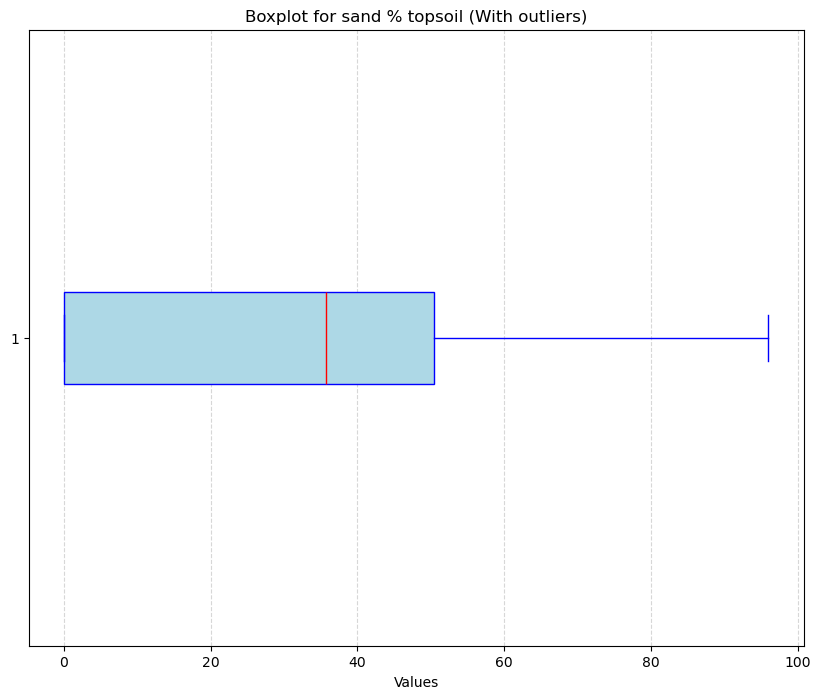

In [143]:
def construct_boxplot(df, column, dispersion_measures):
    plt.figure(figsize=(10, 8))
    boxplot = plt.boxplot(df[column].dropna(), vert=False, patch_artist=True,
                              boxprops=dict(facecolor='lightblue', color='blue'),
                              whiskerprops=dict(color='blue'),
                              capprops=dict(color='blue'),
                              medianprops=dict(color='red'),
                              flierprops=dict(marker='o', color='red', markersize=5))
    
    outliers = df[(df[column] < dispersion_measures[column]['Lower Bound for Outliers']) | (df[column] > dispersion_measures[column]['Upper Bound for Outliers'])][column]

    for i, outlier_value in outliers.items():
        plt.text(outlier_value, 1, f'{outlier_value:.2f}', color='red', fontsize=9, ha='left')
    
    plt.title(f'Boxplot for {column} (With outliers)')
    plt.xlabel('Values')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.show()


for column in columns_numeric_to_analyze:
    construct_boxplot(df_soil_dz_props, column, dispersion_measures)
#     plt.figure(figsize=(10, 8))
#     boxplot = plt.boxplot(df[column].dropna(), vert=False, patch_artist=True,
#                               boxprops=dict(facecolor='lightblue', color='blue'),
#                               whiskerprops=dict(color='blue'),
#                               capprops=dict(color='blue'),
#                               medianprops=dict(color='red'),
#                               flierprops=dict(marker='o', color='red', markersize=5))
    
#     outliers = df[(df[column] < dispersion_measures[column]['Lower Bound for Outliers']) | (df[column] > dispersion_measures[column]['Upper Bound for Outliers'])][column]

#     for i, outlier_value in outliers.items():
#         plt.text(outlier_value, 1, f'{outlier_value:.2f}', color='red', fontsize=9, ha='left')
    
#     plt.title(f'Boxplot for {column} (With outliers)')
#     plt.xlabel('Values')
#     plt.grid(axis='x', linestyle='--', alpha=0.5)

#     plt.show()

##### v. Construct histograms and visualize the data distribution

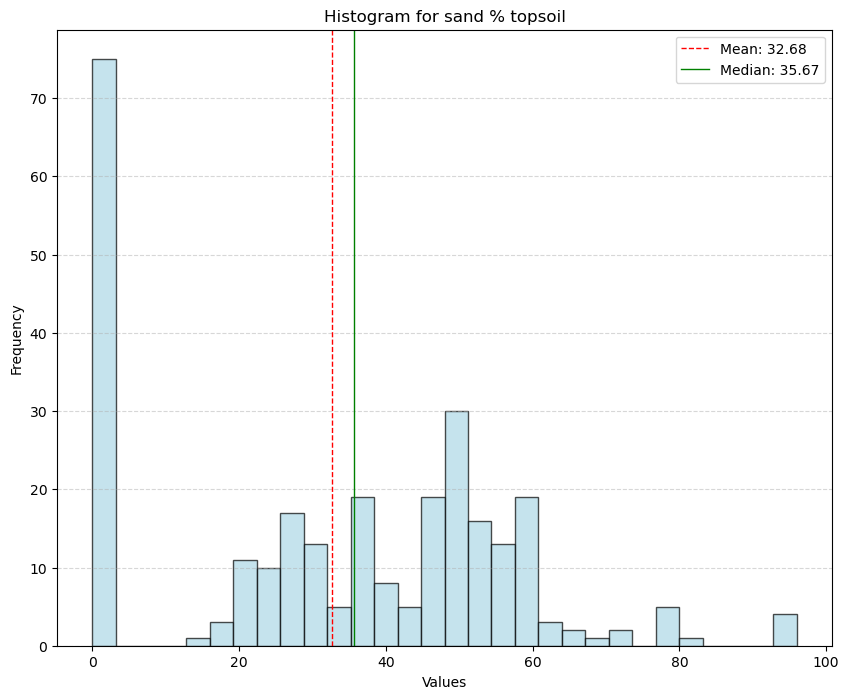

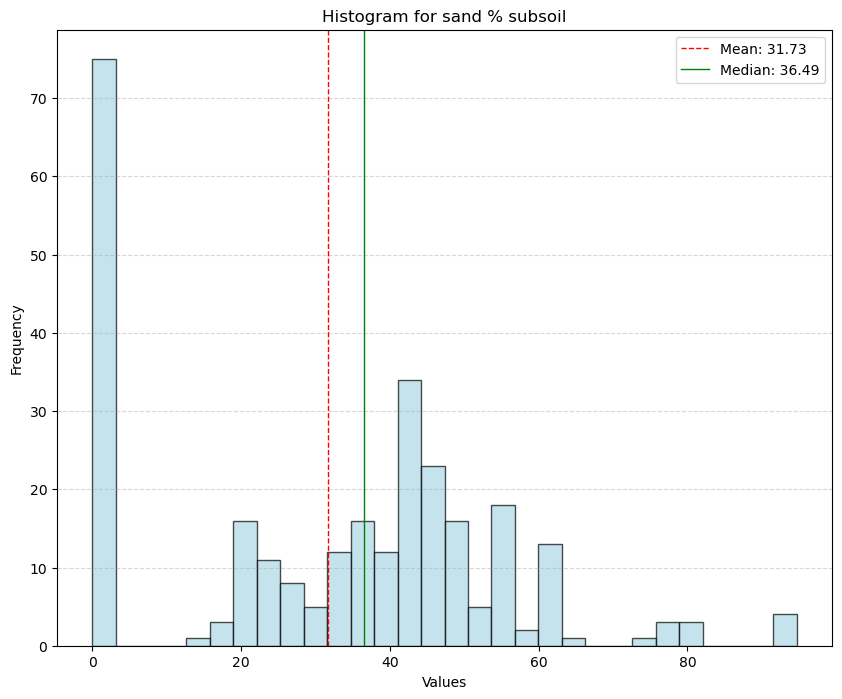

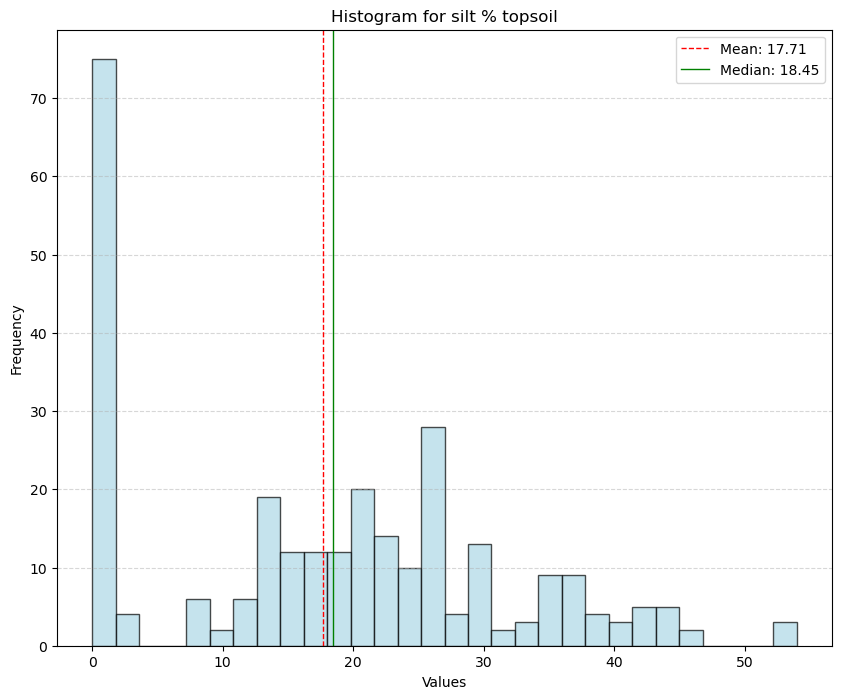

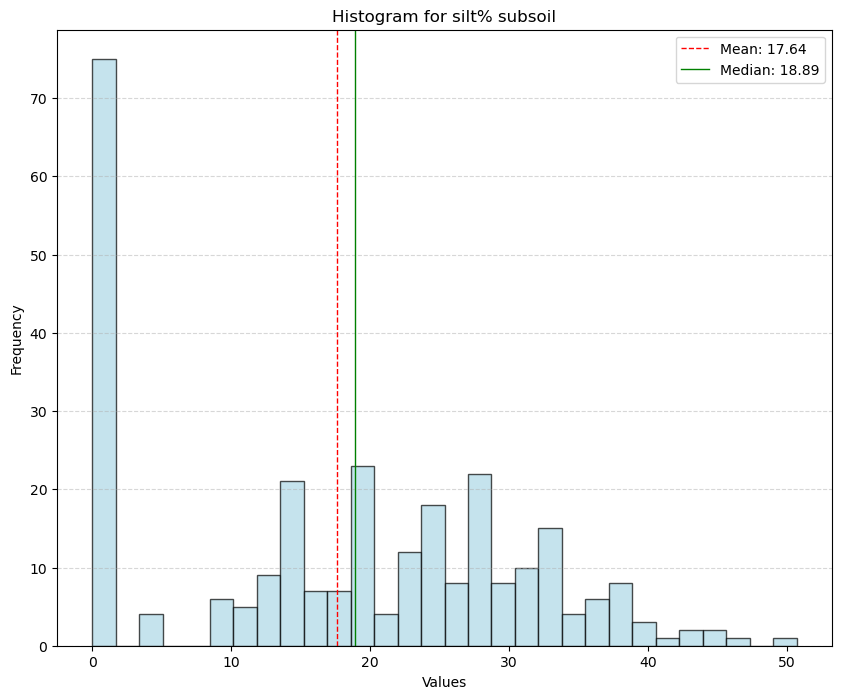

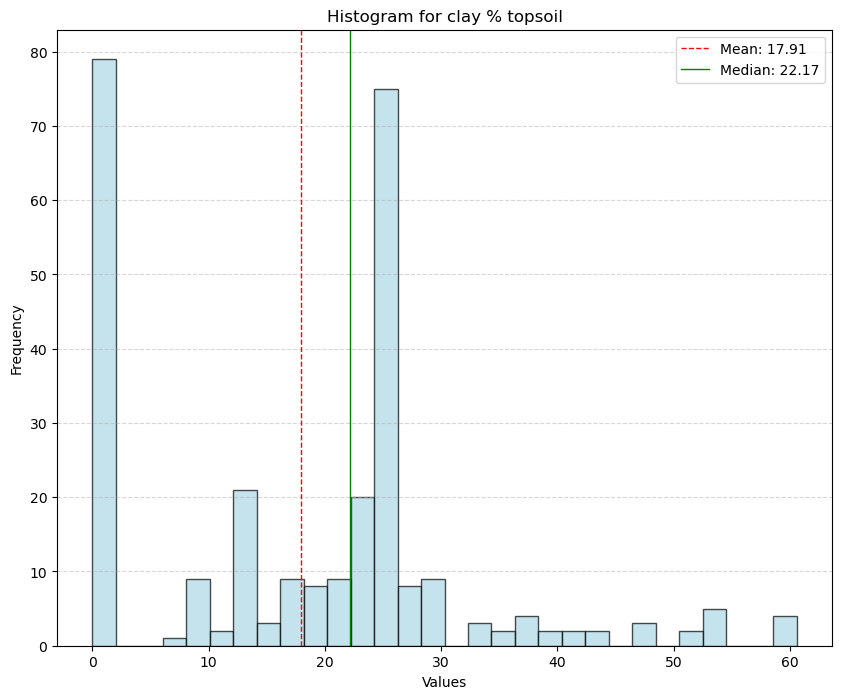

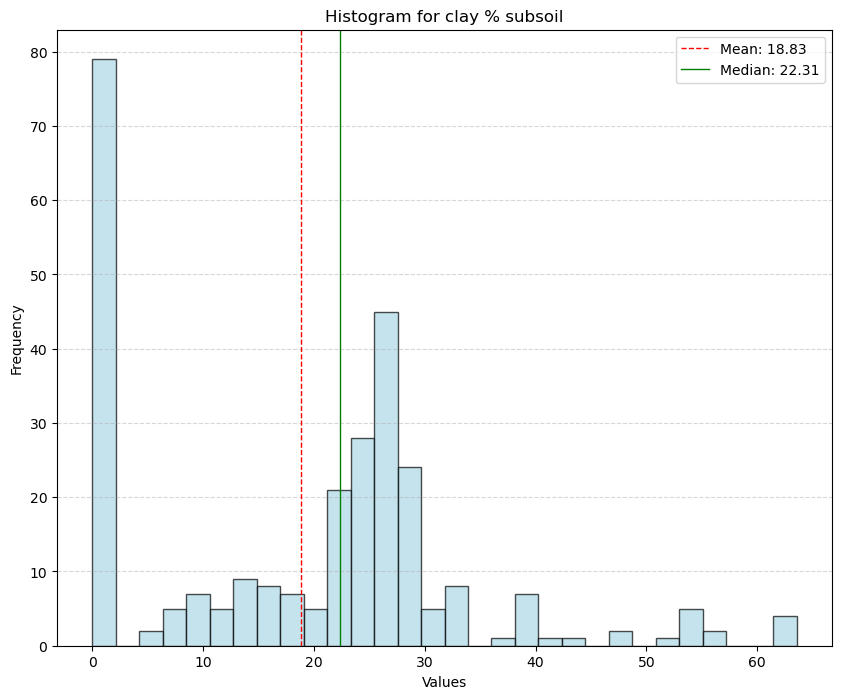

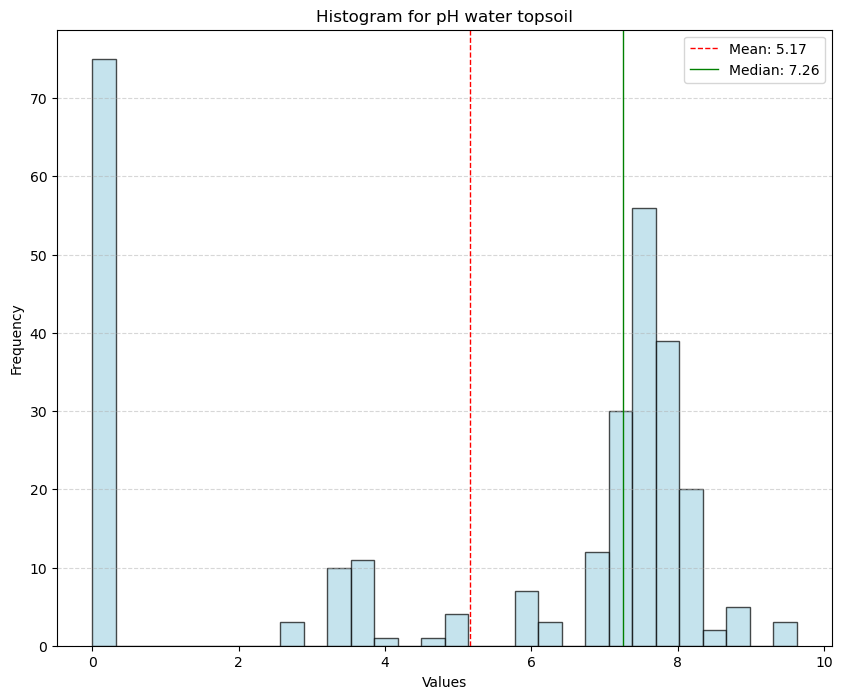

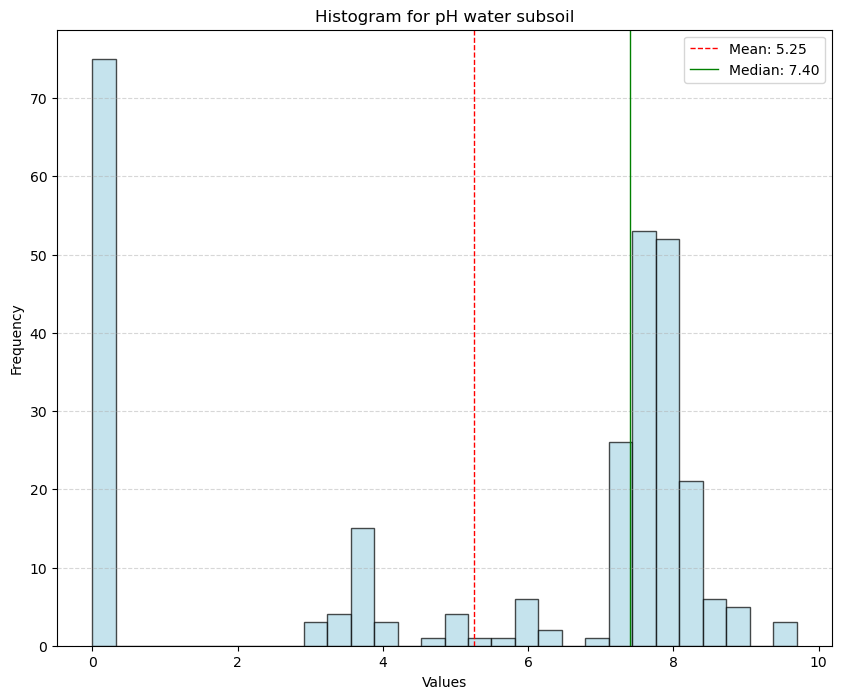

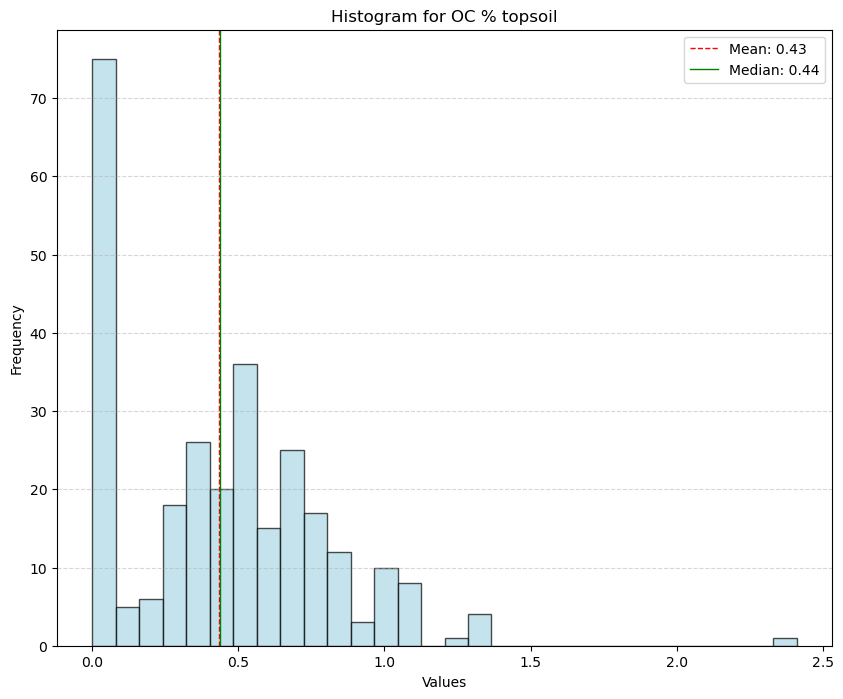

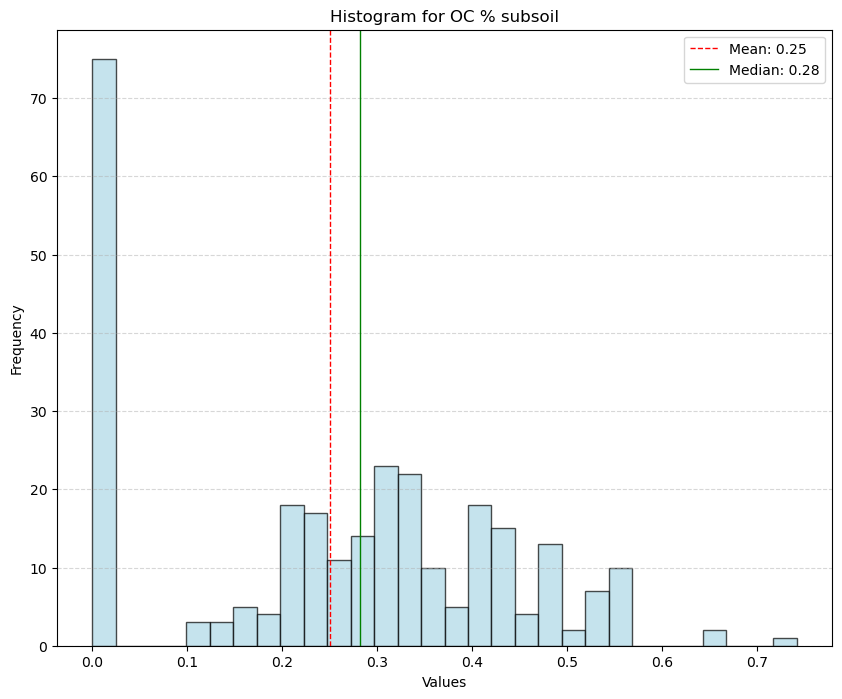

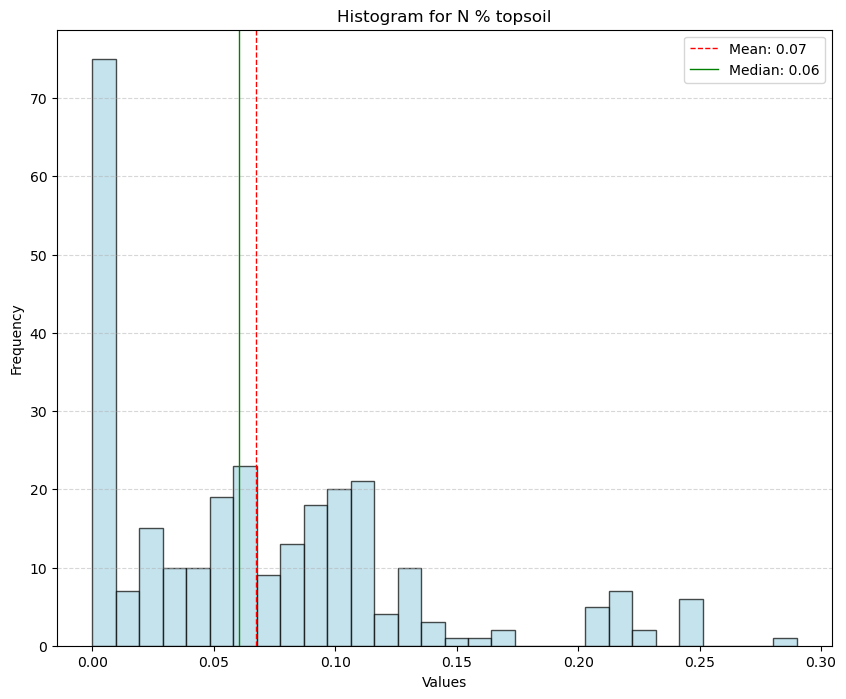

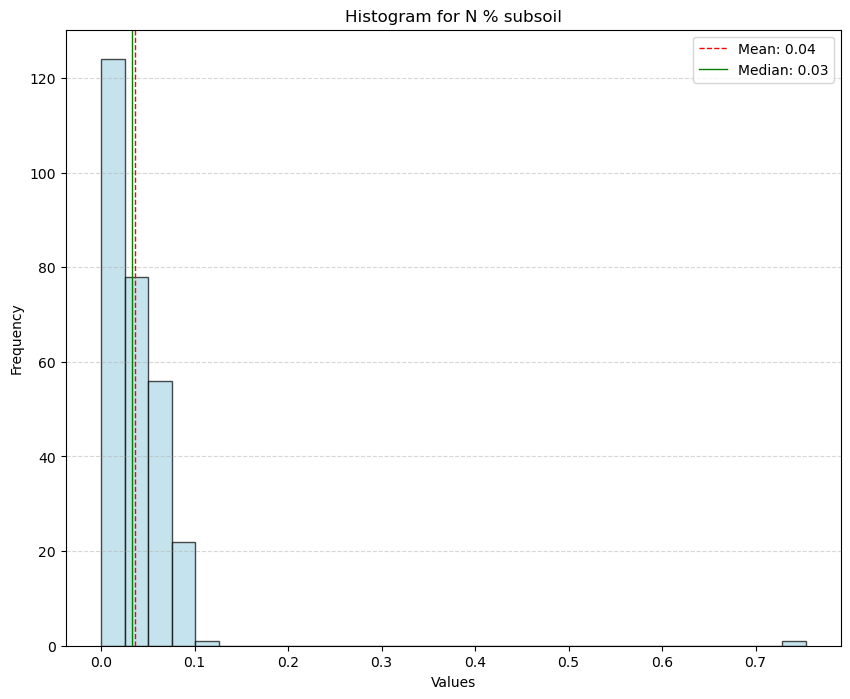

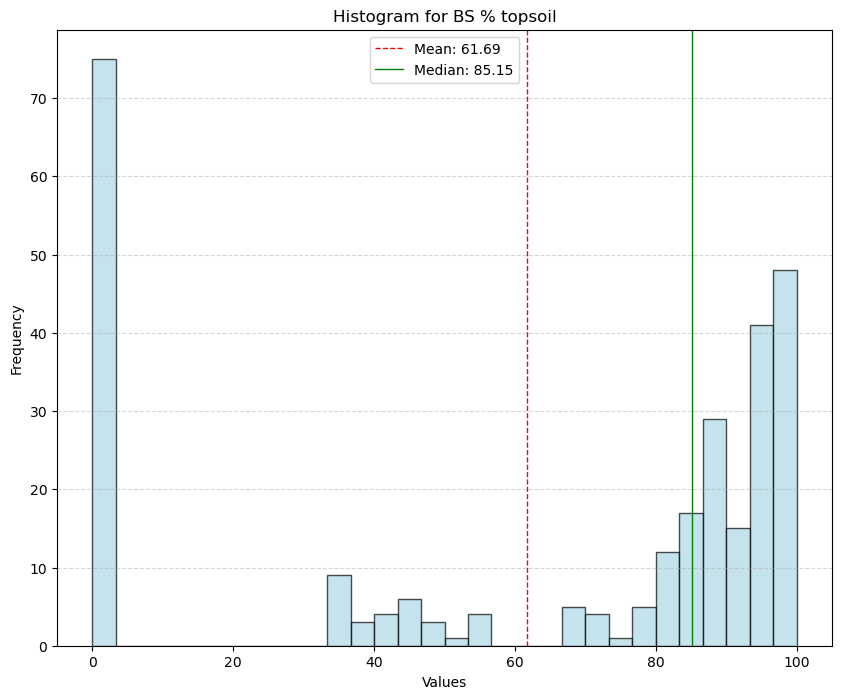

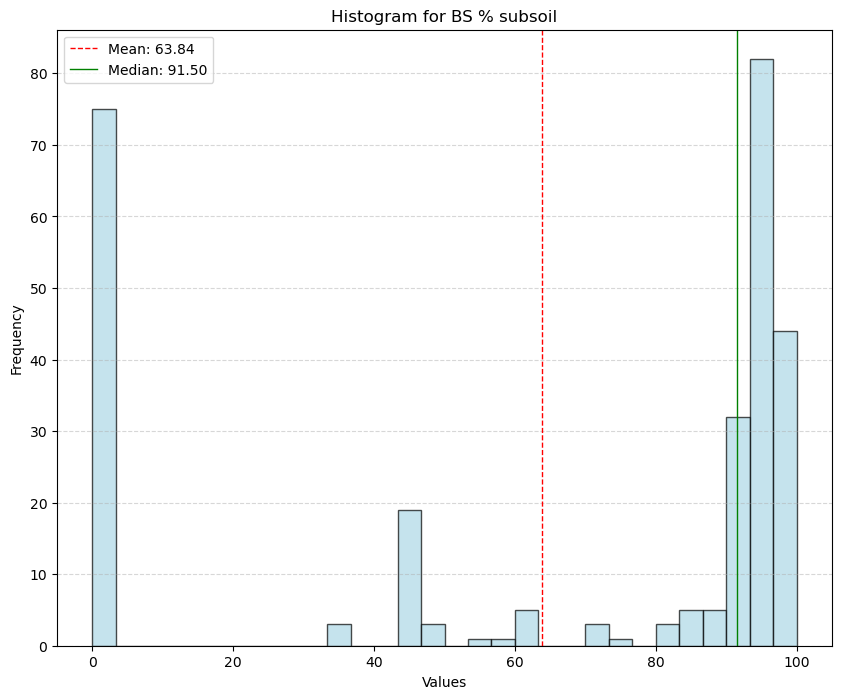

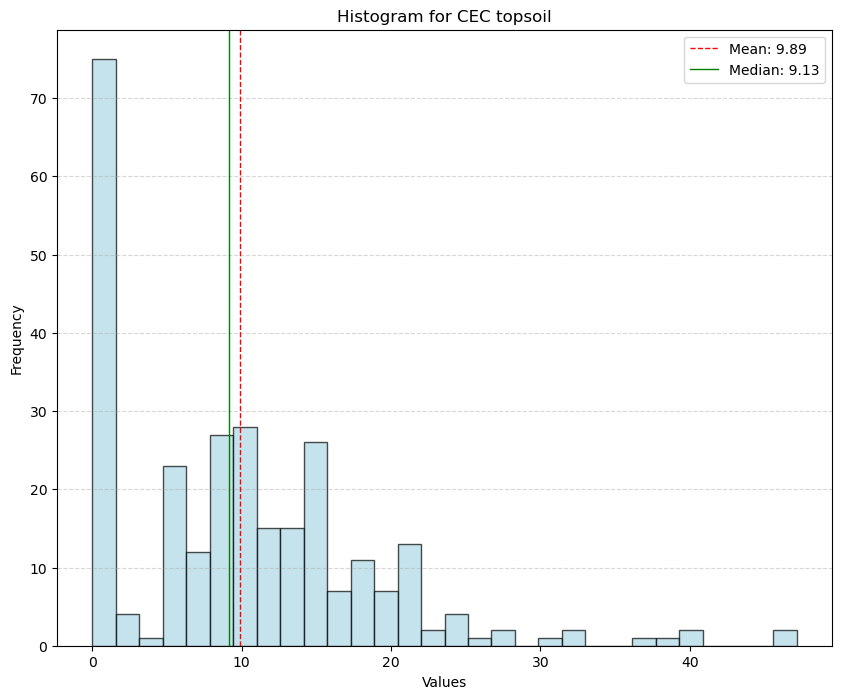

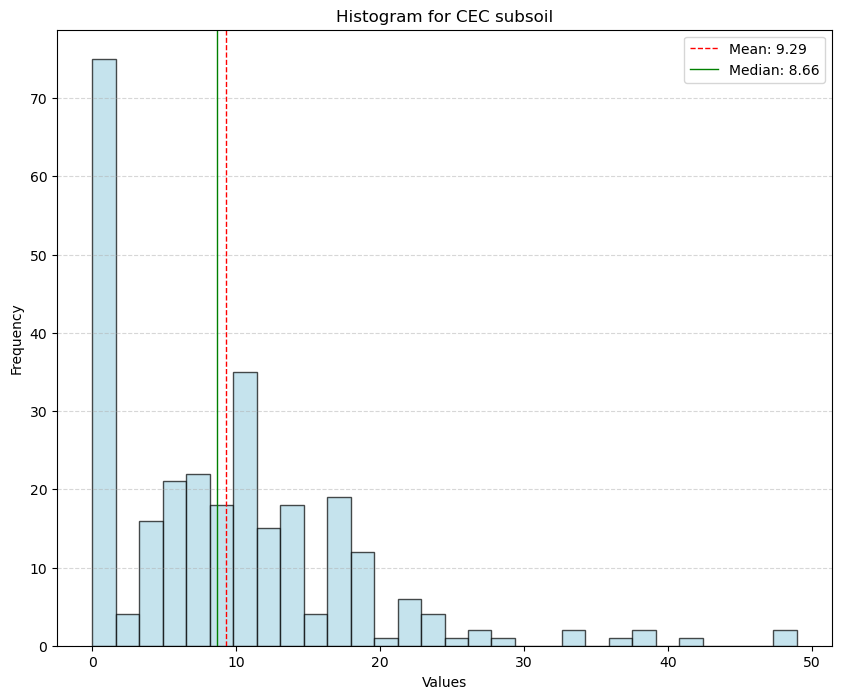

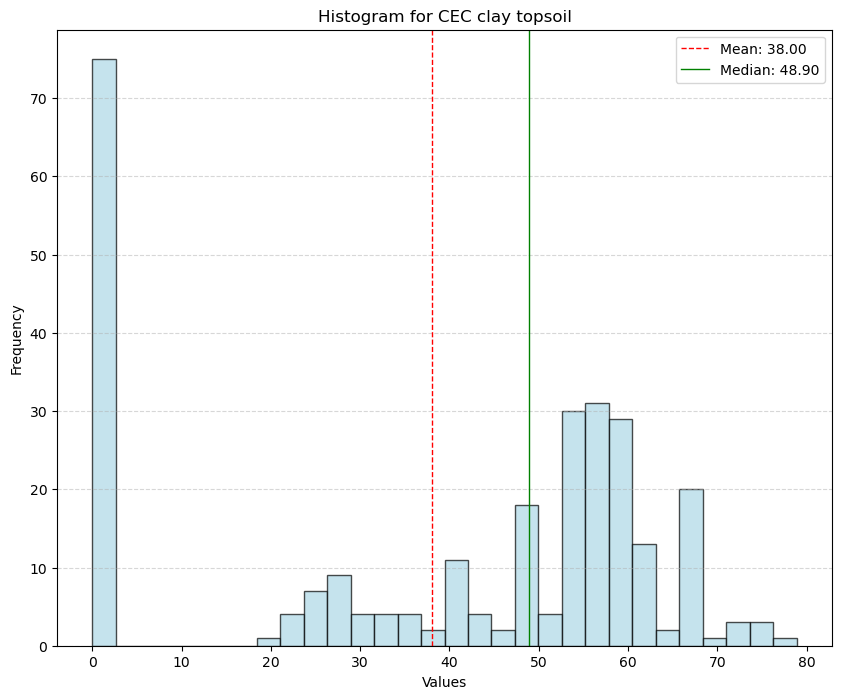

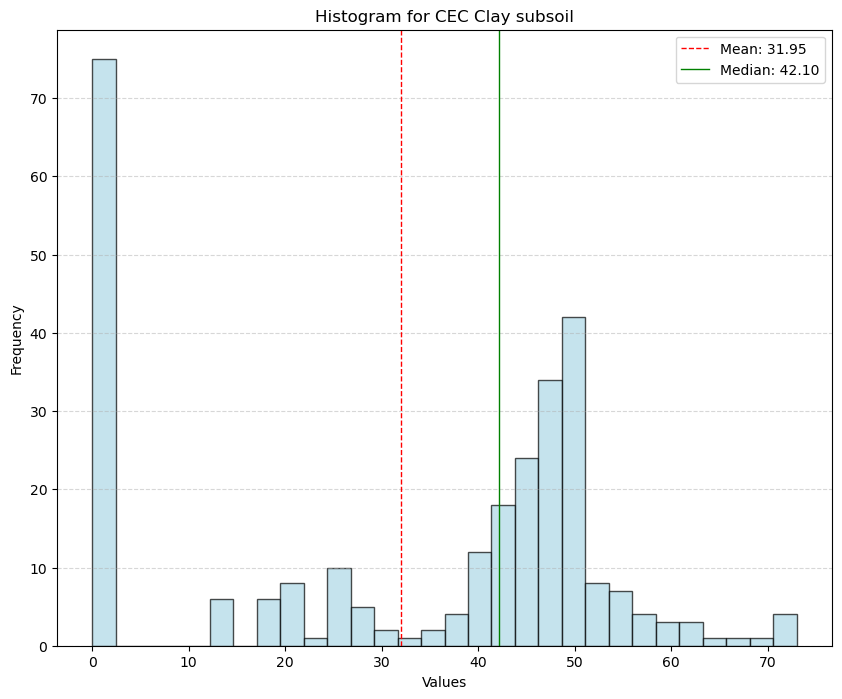

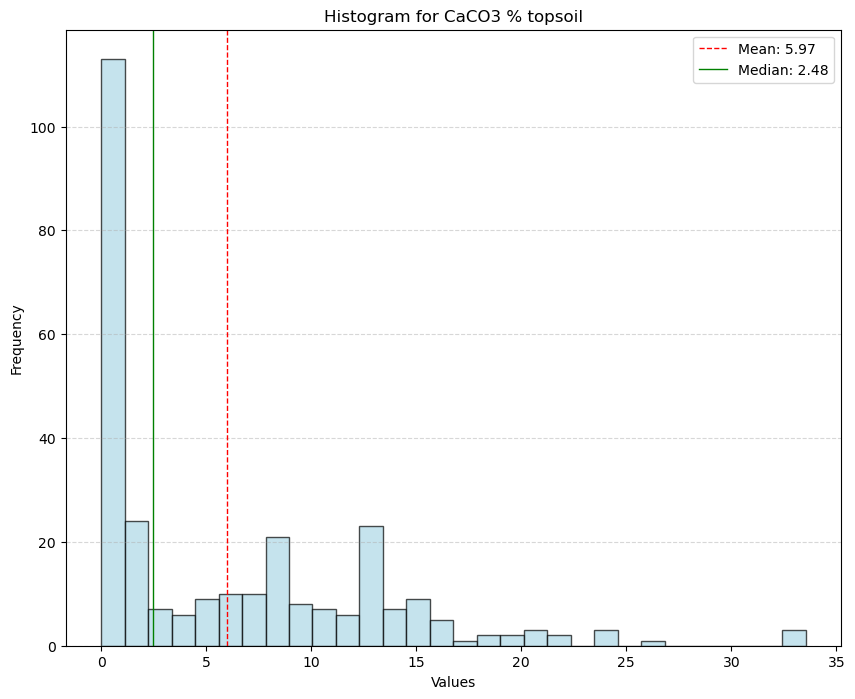

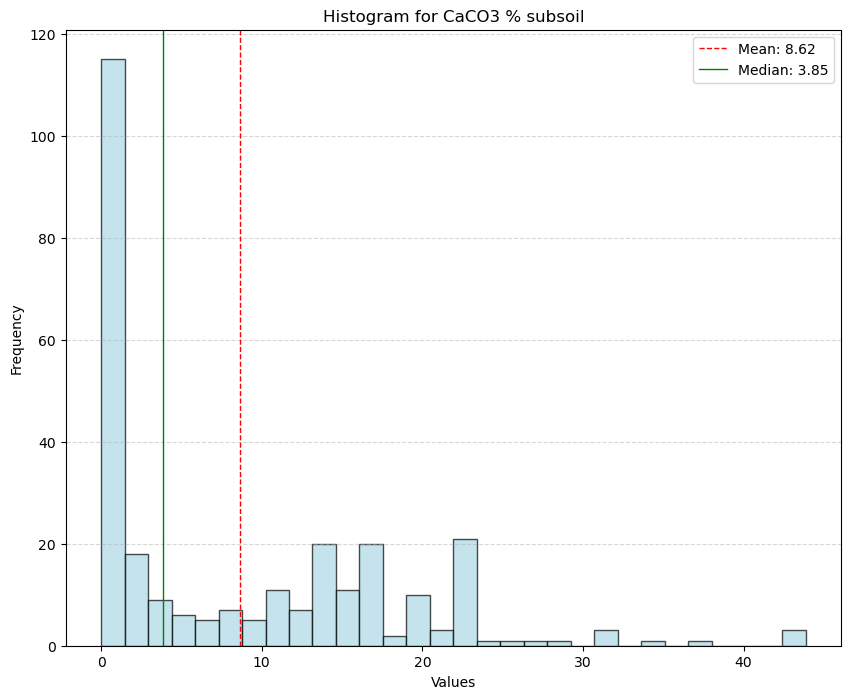

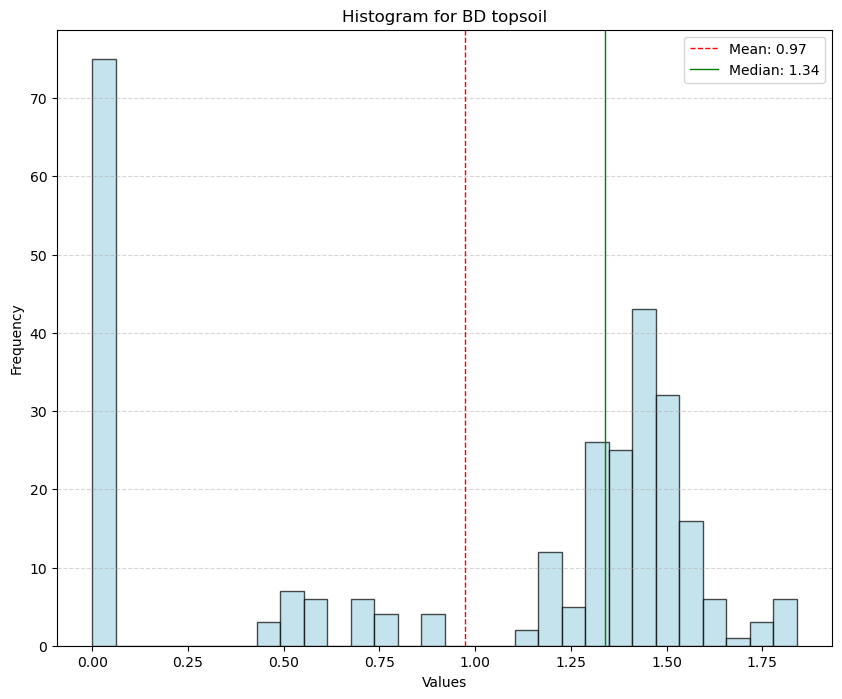

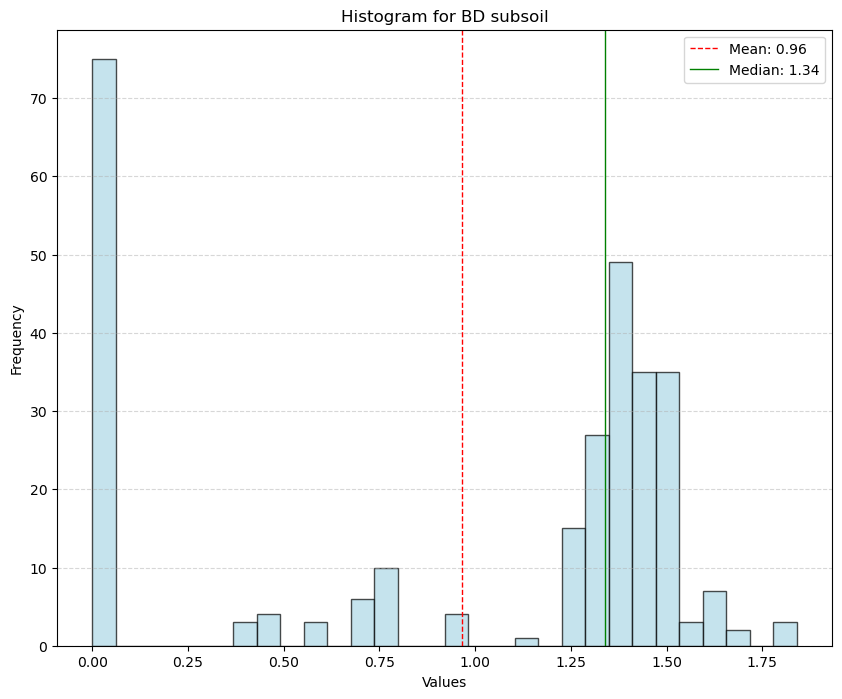

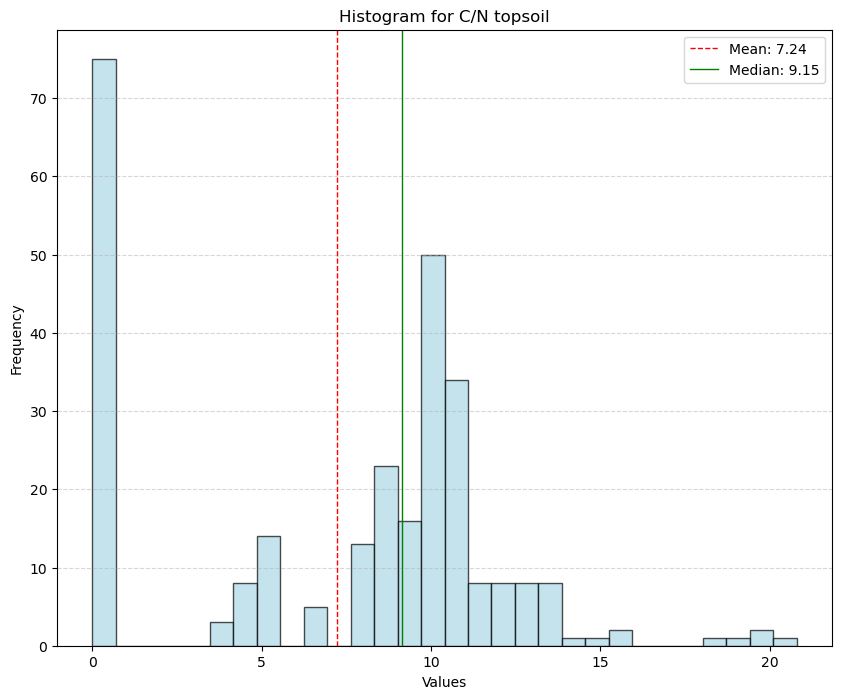

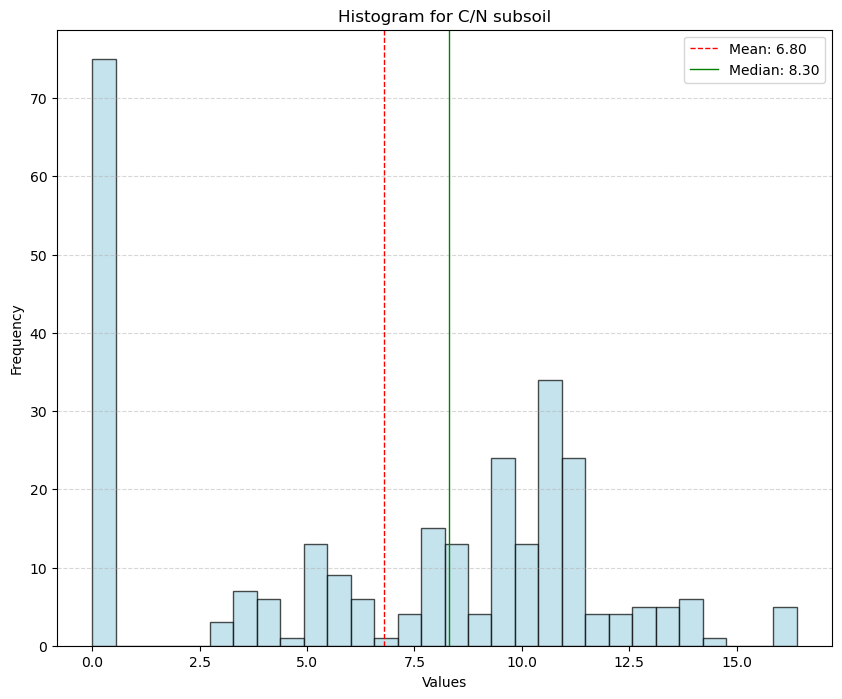

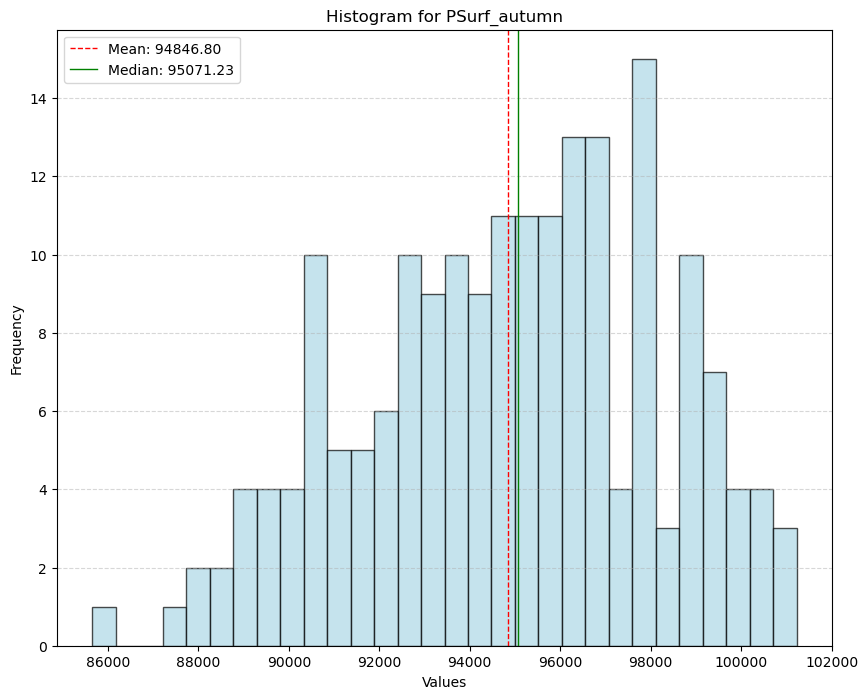

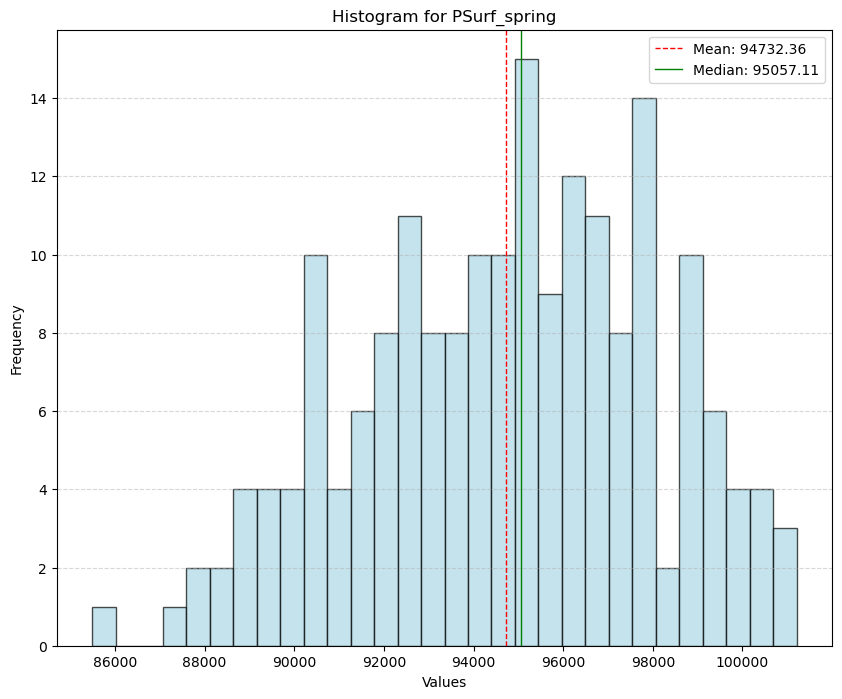

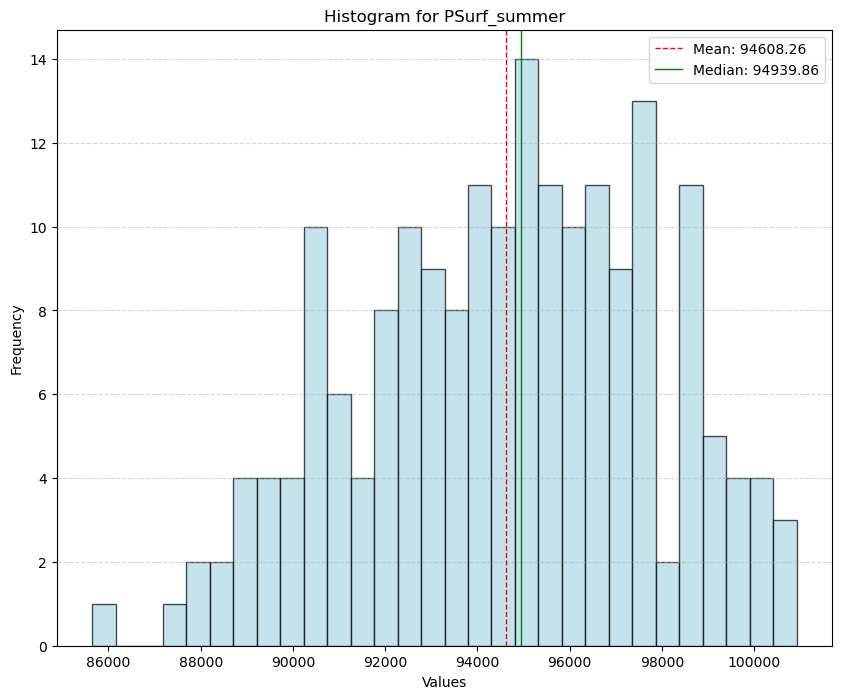

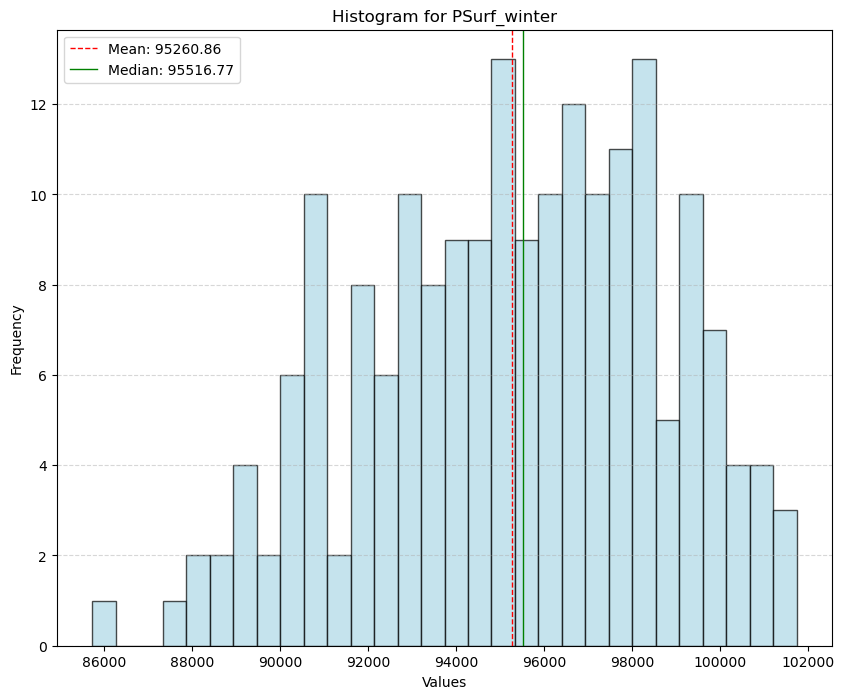

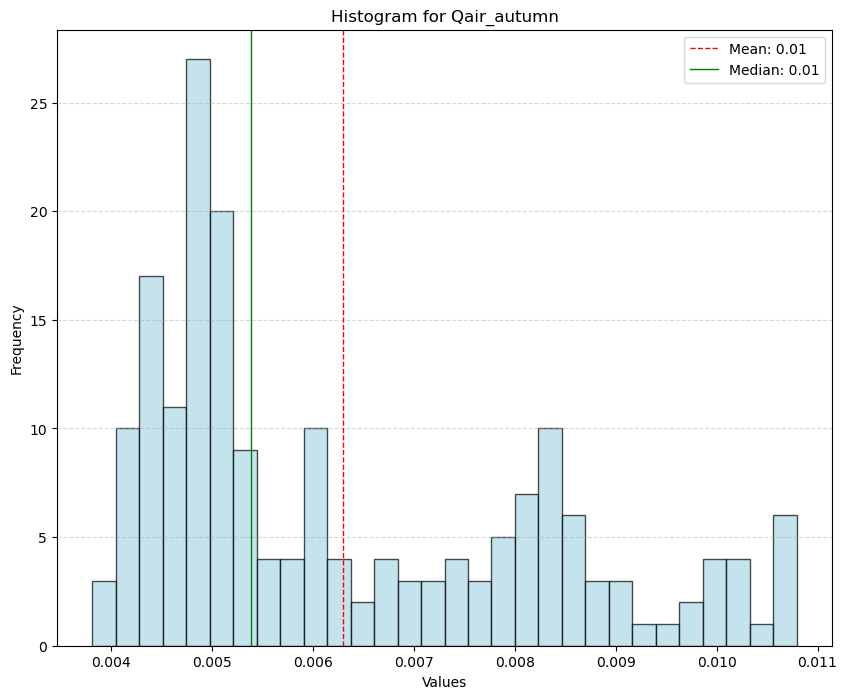

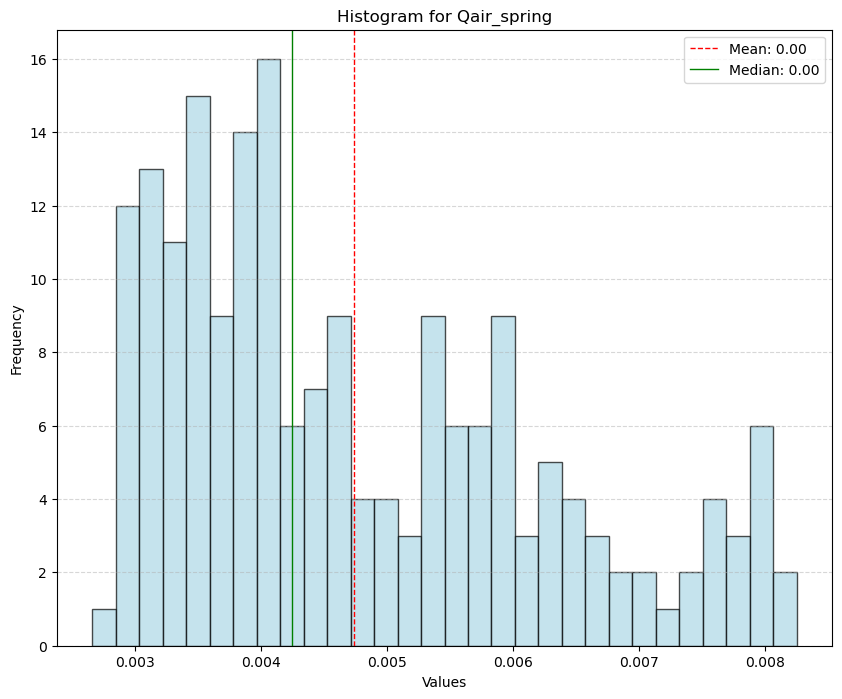

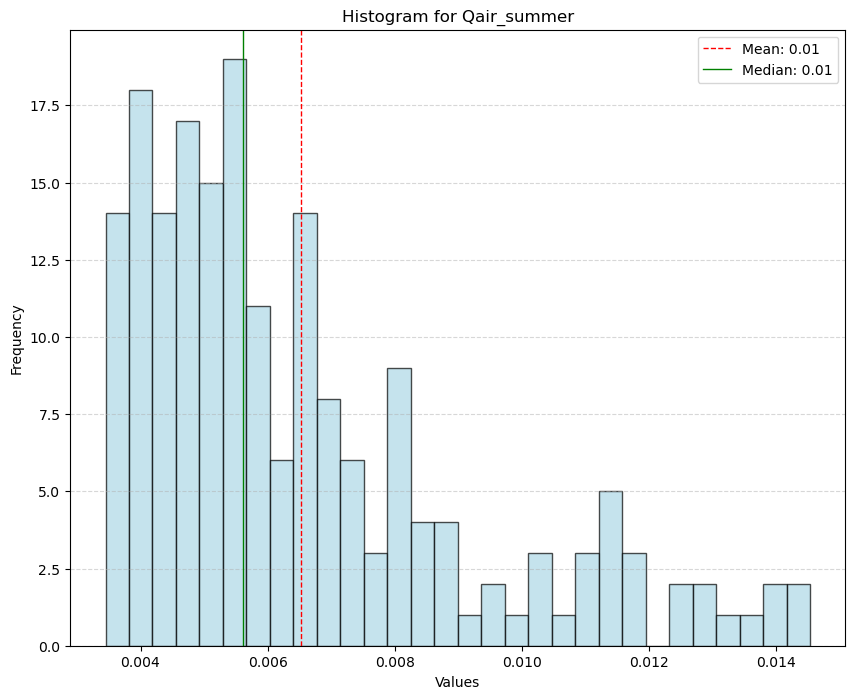

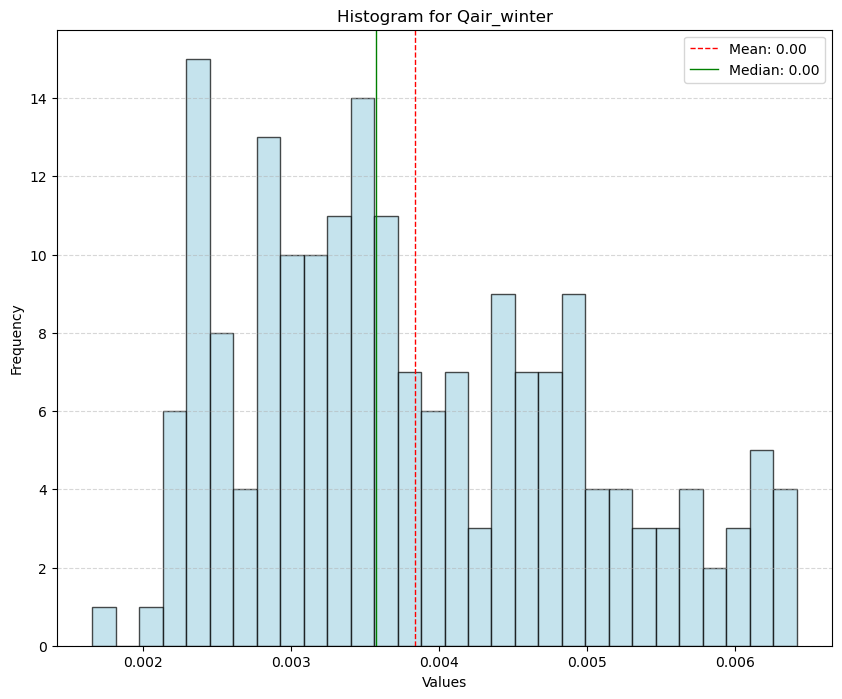

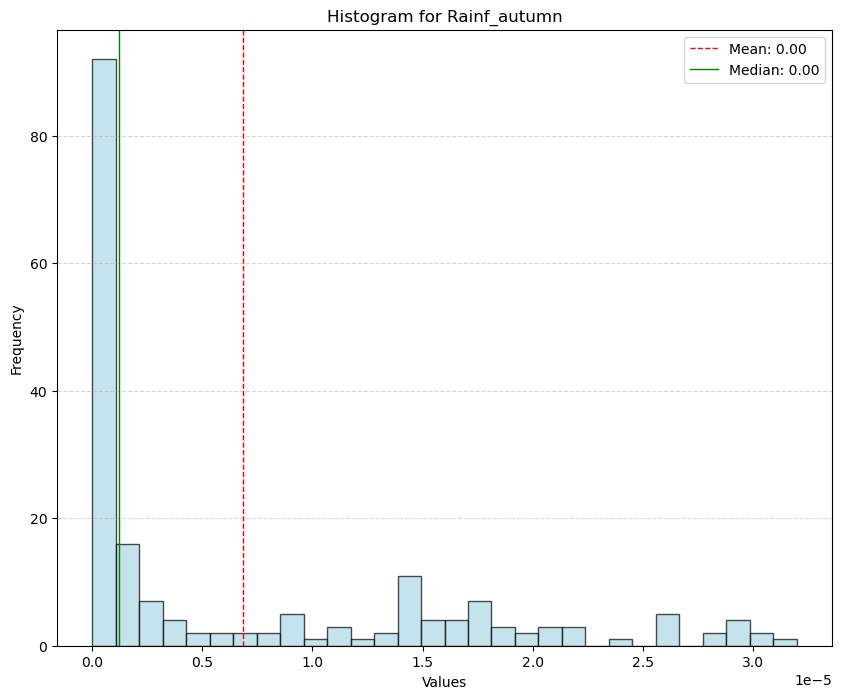

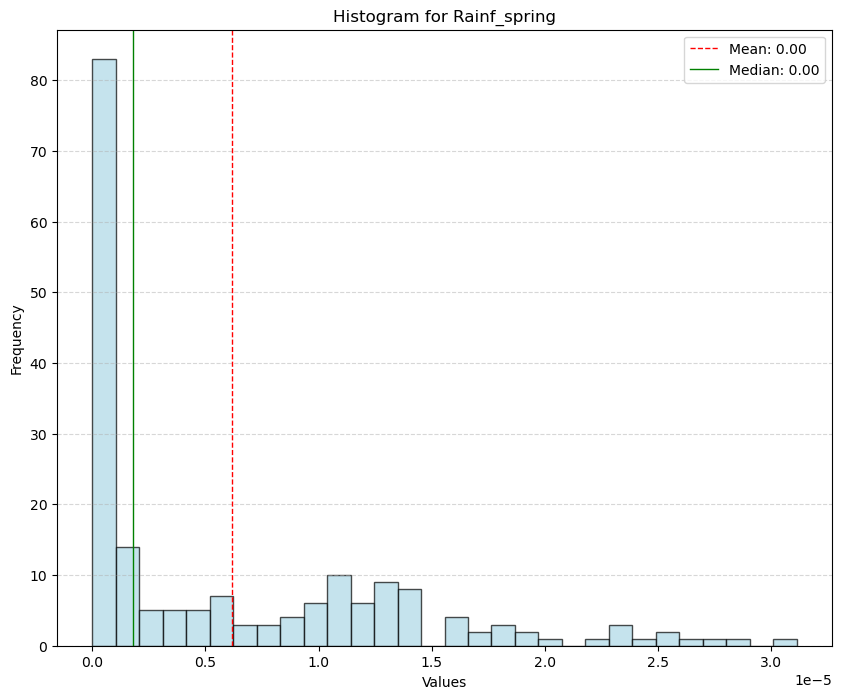

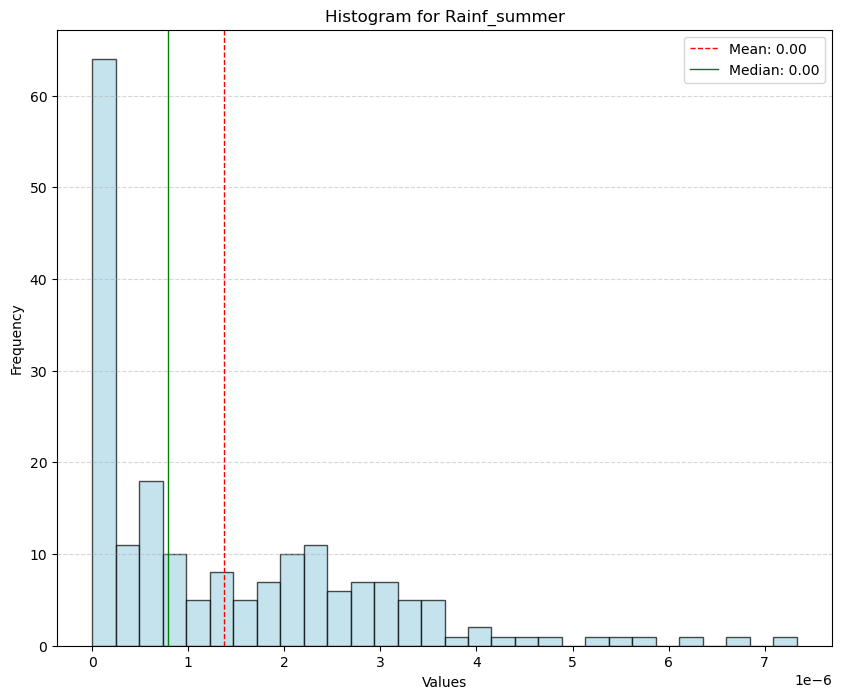

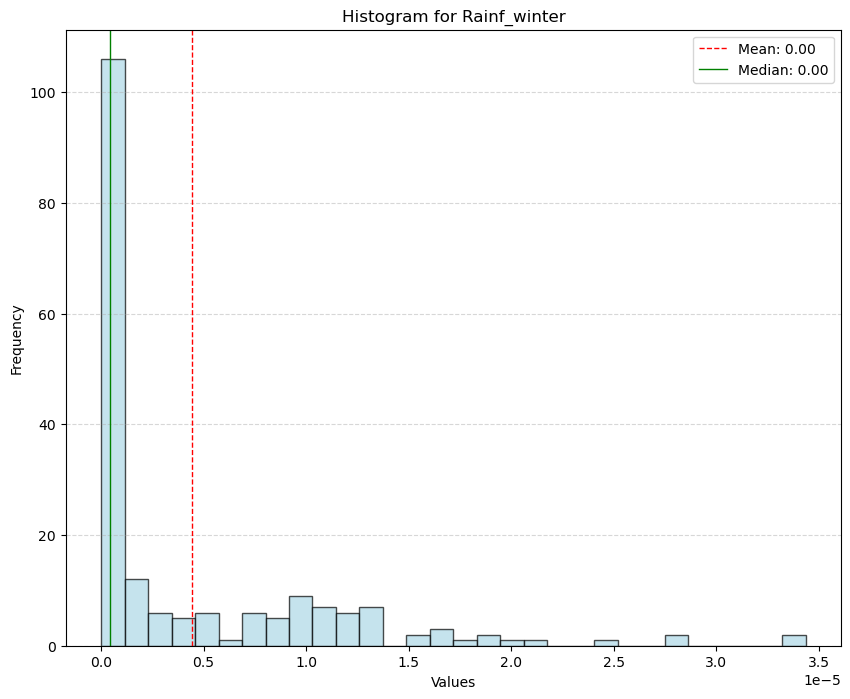

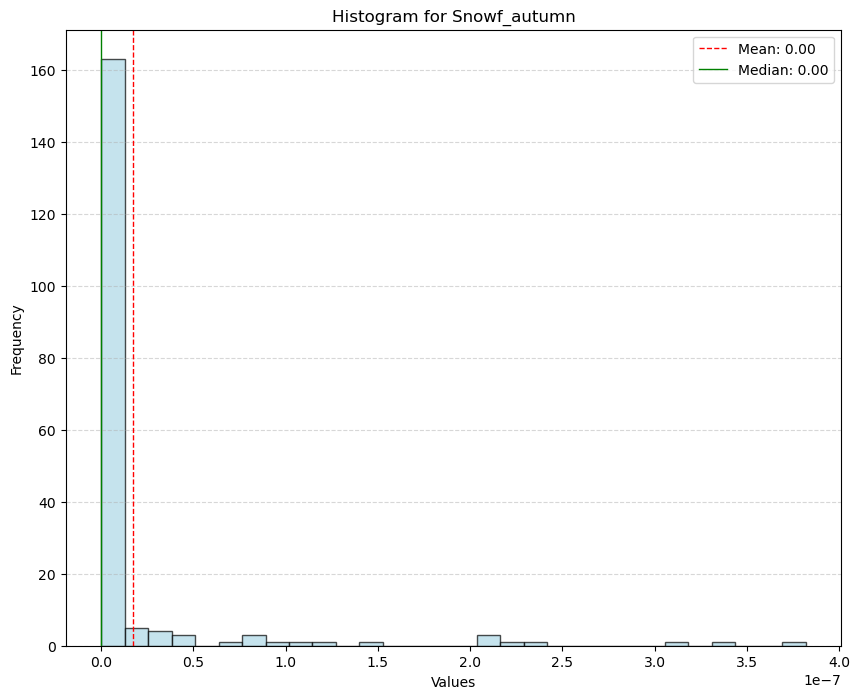

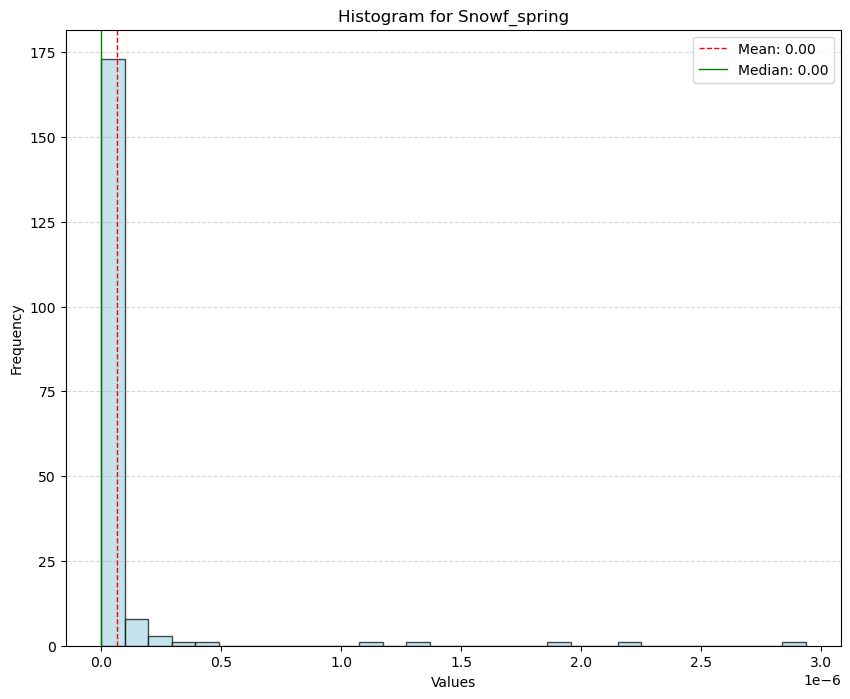

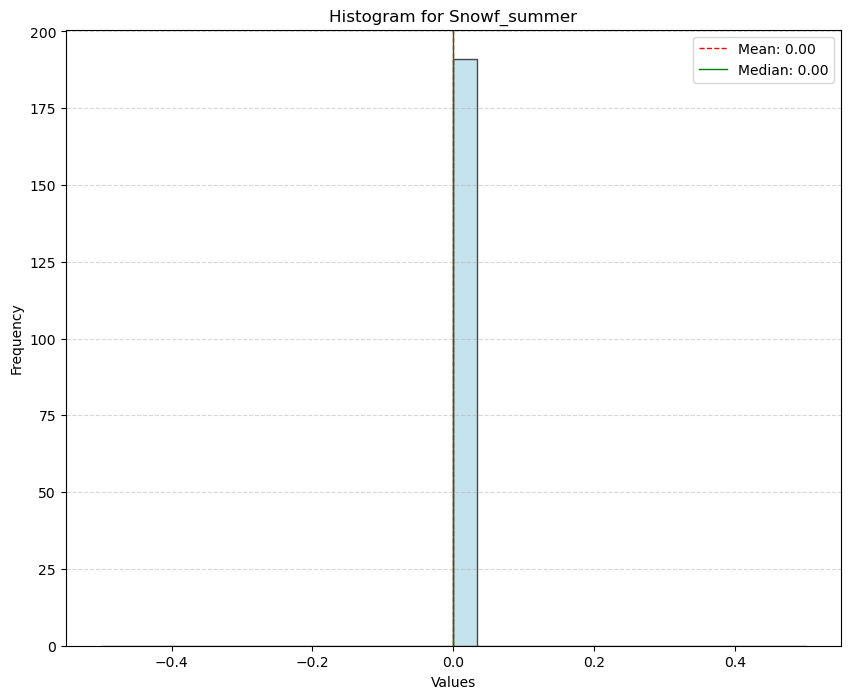

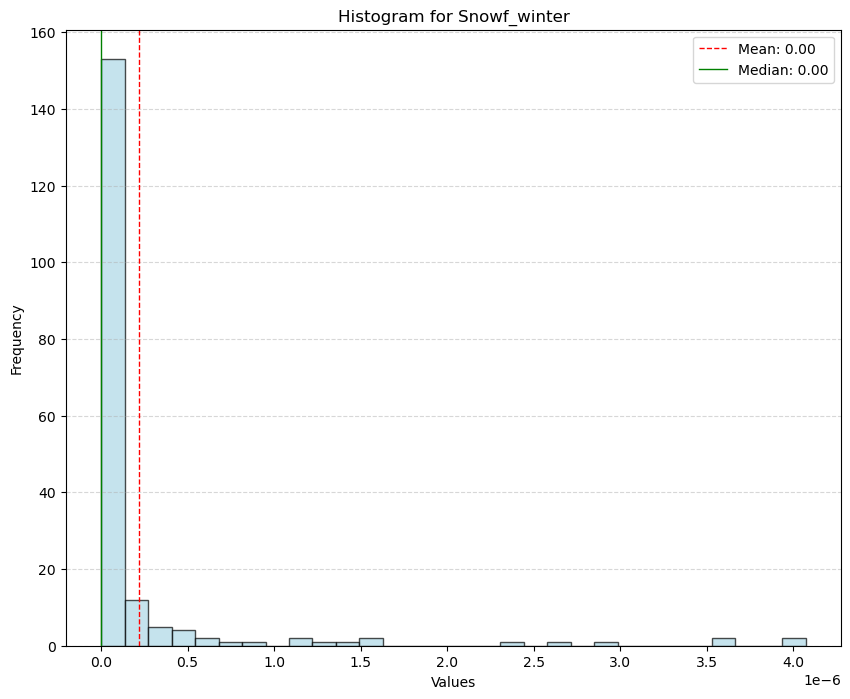

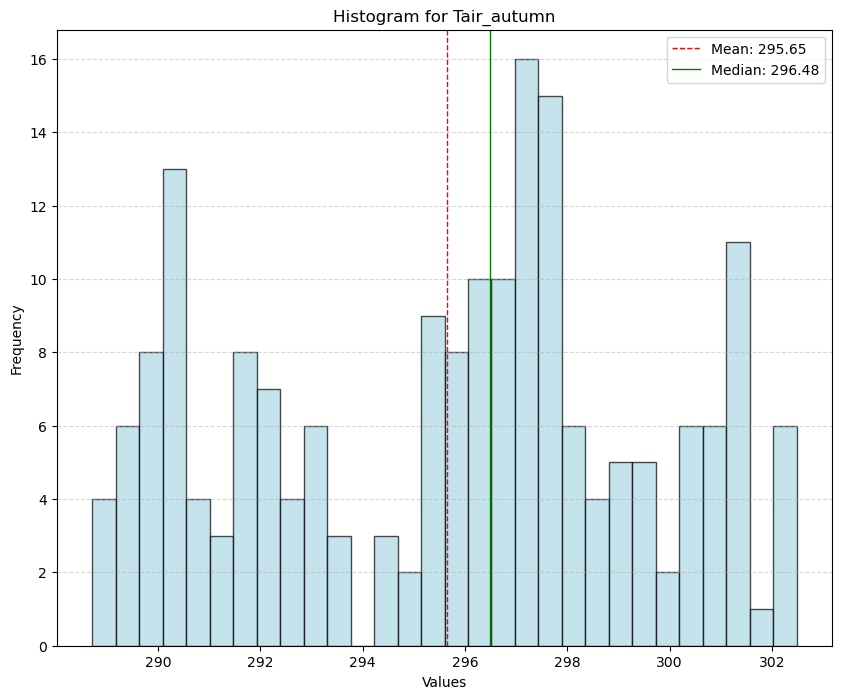

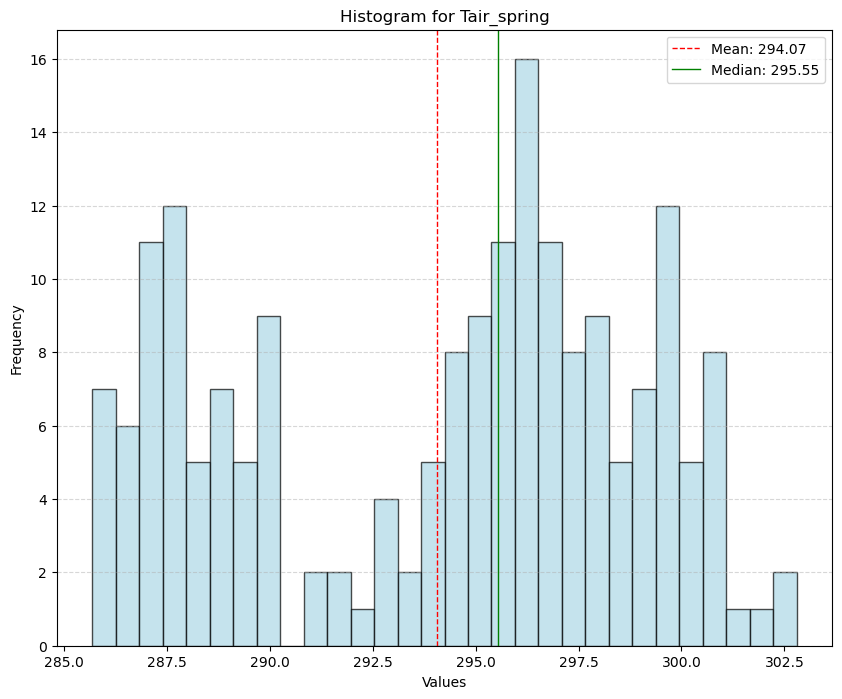

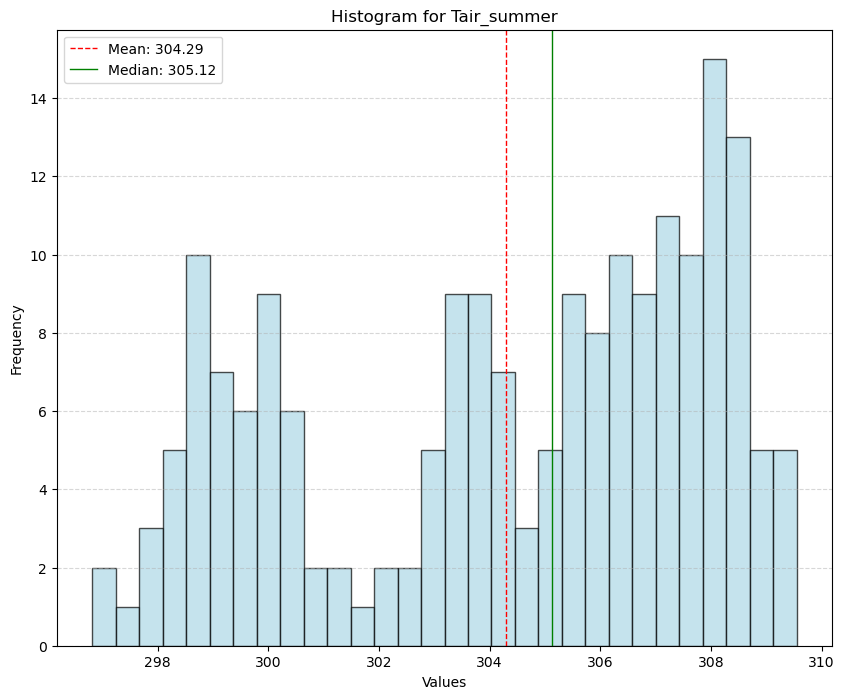

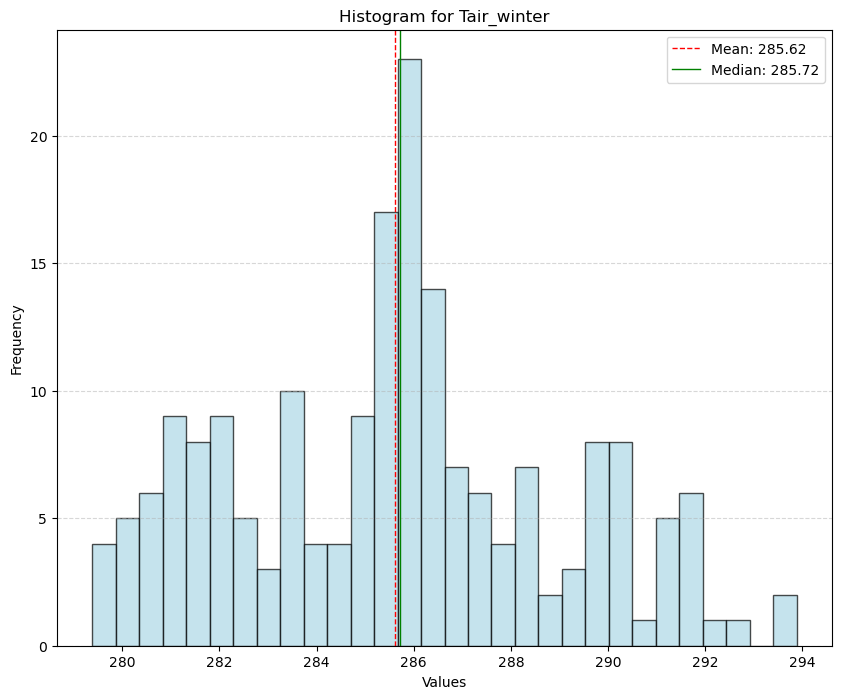

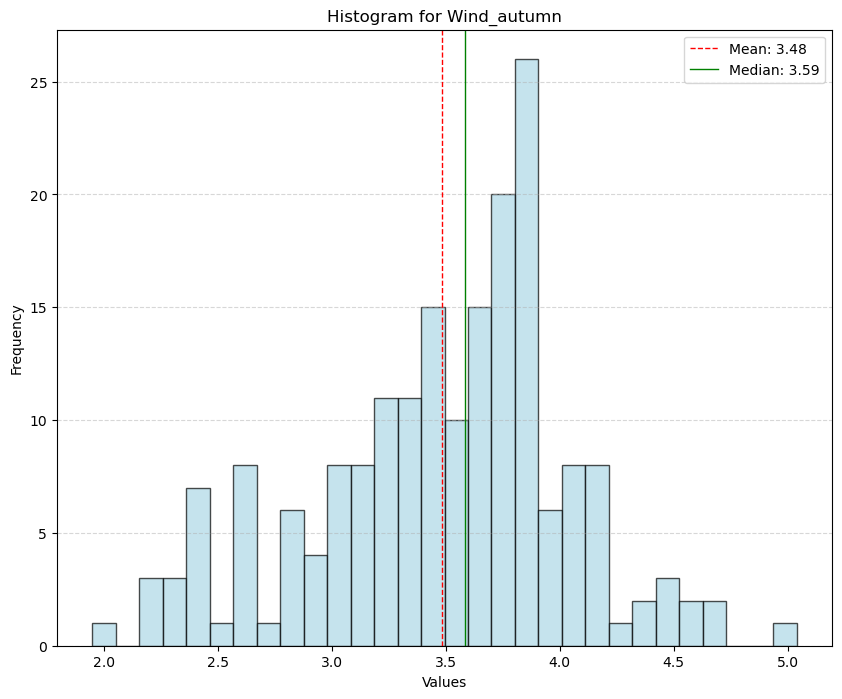

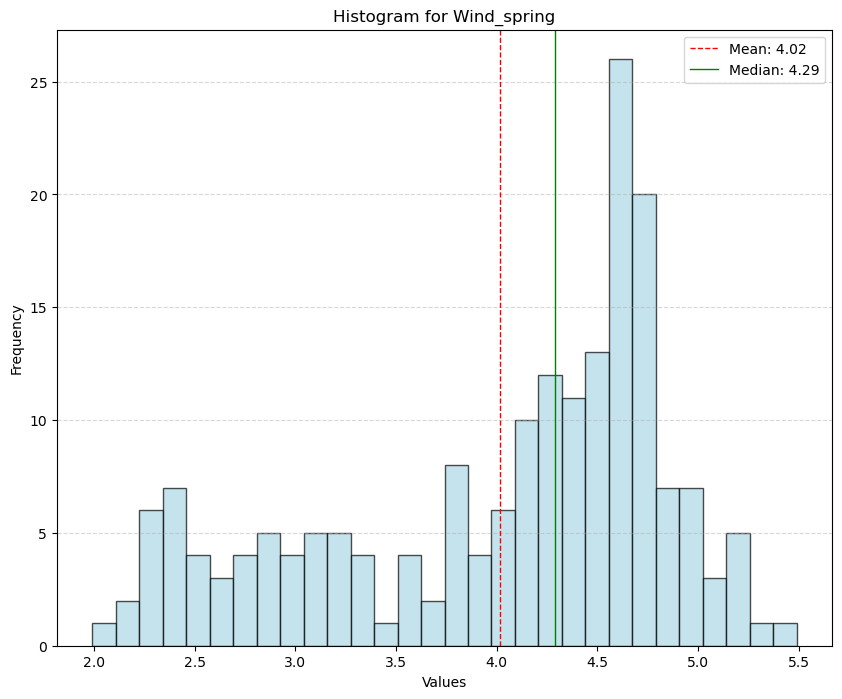

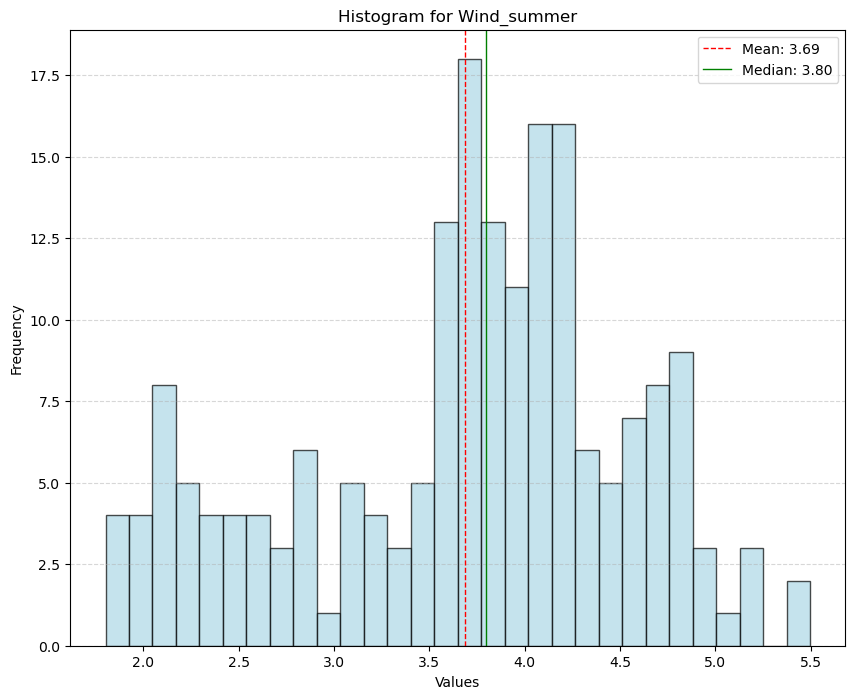

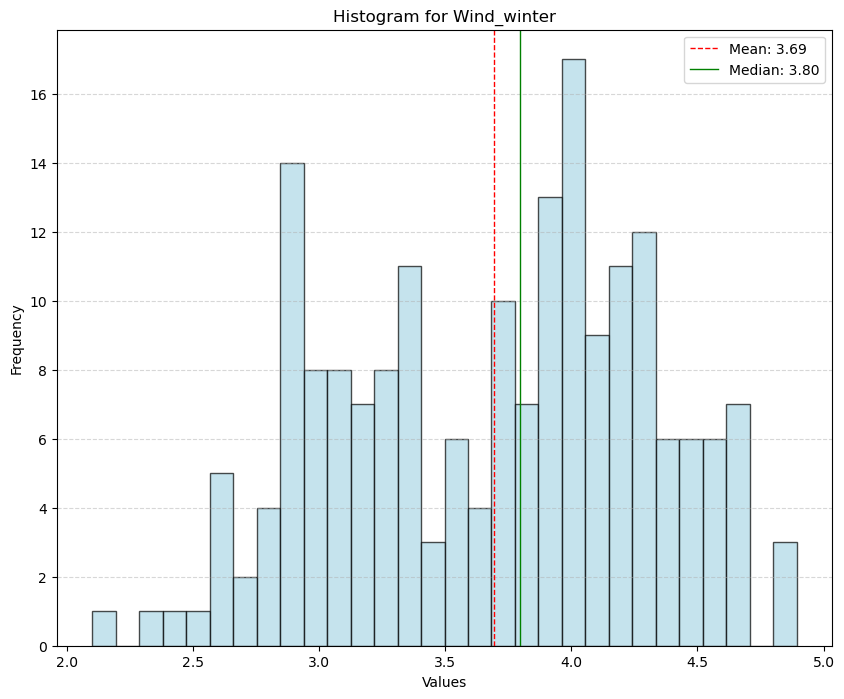

In [80]:
for column in columns_numeric_to_analyze:
    plt.figure(figsize=(10, 8))
    plt.hist(df_soil_dz_props[column].dropna(), bins=30, color='lightblue', edgecolor='black', alpha=0.7)
    

    plt.axvline(tendencies[column]['Mean'], color='red', linestyle='--', linewidth=1, label=f'Mean: {tendencies[column]["Mean"]:.2f}')
    plt.axvline(tendencies[column]['Median'], color='green', linestyle='-', linewidth=1, label=f'Median: {tendencies[column]["Median"]:.2f}')

    
    plt.title(f'Histogram for {column}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.show()

#### b. Construct and display scatter plots of the data and deduce correlations

In [ ]:
def scatter_plot(df,column_x, column_y):
    data_to_plot = df[[column_x, column_y]].dropna()

    plt.figure(figsize=(10, 6))
    plt.scatter(df[column_x], df[column_y], alpha=0.6)

    correlation = df[column_x].corr(df[column_y])


    plt.title(f'Scatter Plot: {column_x} vs {column_y}\nCorrelation: {correlation:.2f}')
    plt.xlabel(column_x)
    plt.ylabel(column_y)

    sns.regplot(x=column_x, y=column_y, data=df, scatter=False, color='red', line_kws={"linewidth": 1})

    plt.grid()
    plt.show()

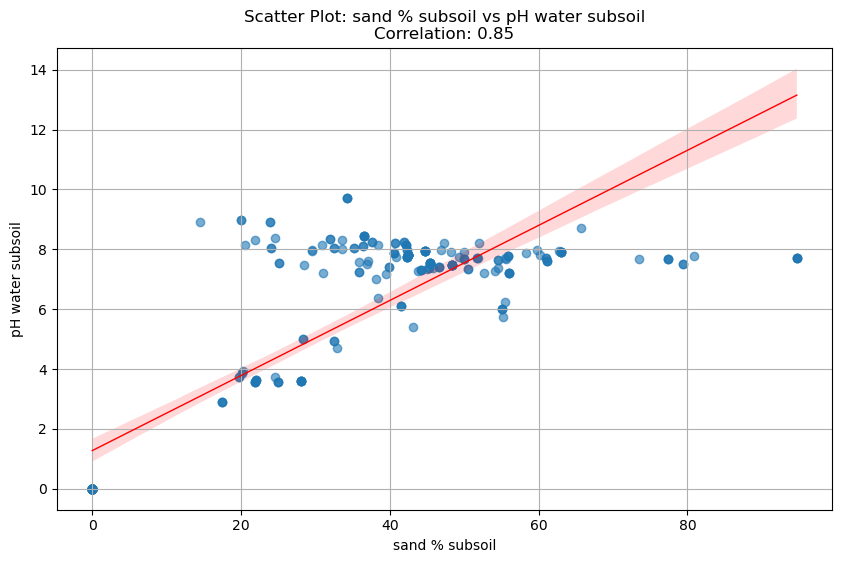

Index(['CNT_FULLNAME', 'sand % topsoil', 'sand % subsoil', 'silt % topsoil',
       'silt% subsoil', 'clay % topsoil', 'clay % subsoil', 'pH water topsoil',
       'pH water subsoil', 'OC % topsoil', 'OC % subsoil', 'N % topsoil',
       'N % subsoil', 'BS % topsoil', 'BS % subsoil', 'CEC topsoil',
       'CEC subsoil', 'CEC clay topsoil', 'CEC Clay subsoil',
       'CaCO3 % topsoil', 'CaCO3 % subsoil', 'BD topsoil', 'BD subsoil',
       'C/N topsoil', 'C/N subsoil', 'geometry', 'PSurf_autumn',
       'PSurf_spring', 'PSurf_summer', 'PSurf_winter', 'Qair_autumn',
       'Qair_spring', 'Qair_summer', 'Qair_winter', 'Rainf_autumn',
       'Rainf_spring', 'Rainf_summer', 'Rainf_winter', 'Snowf_autumn',
       'Snowf_spring', 'Snowf_summer', 'Snowf_winter', 'Tair_autumn',
       'Tair_spring', 'Tair_summer', 'Tair_winter', 'Wind_autumn',
       'Wind_spring', 'Wind_summer', 'Wind_winter'],
      dtype='object')


In [103]:
scatter_plot(df_soil_dz_props, 'sand % subsoil', 'pH water subsoil')
print(df_soil_dz_props.columns)

## C. Data reduction through aggregation by seasons

## D. Data integration: merges data from multiple sources into a single coherent dataset

In [142]:
# DONE

## E. Multiple choices of handling outliers and missing values

#### Handling outliers

##### outliers

In [158]:
def remove_outliers_iqr(df, column, dispersion_measures):
    lower_bound = dispersion_measures[column]['Lower Bound for Outliers']
    upper_bound = dispersion_measures[column]['Upper Bound for Outliers']
    
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_no_outliers 

def remove_outliers_zscore(df, column, threshold=3):
    mean = df[column].mean()
    std_dev = df[column].std()

    z_scores = (df[column] - mean) / std_dev

    df_no_outliers = df[abs(z_scores) <= threshold]
    
    return df_no_outliers

#### Missing values

##### filtering out missing data

In [128]:
def drop_rows_na(df):
    return df.dropna()

# df_after_drpna = drop_rows_na(df)
# print(df_after_drpna.info())

def drop_rows_all_na(df):
    return df.dropna(how='all')

# df_after_drpna_all = drop_rows_all_na(df)
# print(df_after_drpna_all.info())


def drop_columns_na(df):
    return df.dropna(axis="columns")

# df_after_drpna = drop_columns_na(df)
# print(df_after_drpna.info())

def drop_columns_all_na(df):
    return df.dropna(axis="columns", how='all')

# df_after_drpna_all = drop_columns_all_na(df)
# print(df_after_drpna_all.info())

def drop_rows_thresh_na(df, th):
    return df.dropna(thresh = th)

# df_after_drpna = drop_rows_thresh_na(df, 10)
# print(df_after_drpna.info()) 

##### filling in missing data

In [141]:
def fill_na(df,value):
    return df.fillna(value)

# df_after_fillna = fill_na(df, 0)
# print(df_after_fillna.info())

def fill_dict_na(df, dict):
    return df.fillna(dict)

# df_after_fillna_dict = fill_dict_na(df, {'PSurf_winter': df['PSurf_winter'].median(), 'PSurf_autumn': df['PSurf_autumn'].median()})
# print(df_after_fillna_dict.info())

def fill_forward_na(df, limit=None):
    return df.fillna(method="ffill", limit=limit)

# df_after_fillna_ffill = fill_forward_na(df)
# print(df_after_fillna_ffill.info())

def fill_backward_na(df, limit=None):
    return df.fillna(method="bfill", limit=limit)

# df_after_fillna_backward = fill_backward_na(df)
# print(df_after_fillna_backward.info())

def fill_mean_na(df):
    inter_df = df
    for column in inter_df.columns:
        if pd.api.types.is_numeric_dtype(inter_df[column]):
            inter_df[column].fillna(inter_df[column].mean(), inplace=True)
    return inter_df

# df_after_fillna_mean = fill_mean_na(df)
# print(df_after_fillna_mean.info())

def fill_median_na(df):
    inter_df = df
    for column in inter_df.columns:
        if pd.api.types.is_numeric_dtype(inter_df[column]):
            inter_df[column].fillna(inter_df[column].median(), inplace=True)
    return inter_df

df_after_fillna_median = fill_median_na(df_soil_dz_props)
print(df_after_fillna_median.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CNT_FULLNAME      282 non-null    object 
 1   sand % topsoil    282 non-null    float64
 2   sand % subsoil    282 non-null    float64
 3   silt % topsoil    282 non-null    float64
 4   silt% subsoil     282 non-null    float64
 5   clay % topsoil    282 non-null    float64
 6   clay % subsoil    282 non-null    float64
 7   pH water topsoil  282 non-null    float64
 8   pH water subsoil  282 non-null    float64
 9   OC % topsoil      282 non-null    float64
 10  OC % subsoil      282 non-null    float64
 11  N % topsoil       282 non-null    float64
 12  N % subsoil       282 non-null    float64
 13  BS % topsoil      282 non-null    float64
 14  BS % subsoil      282 non-null    float64
 15  CEC topsoil       282 non-null    float64
 16  CEC subsoil       282 non-null    float64
 1

C:\Users\DropZone\AppData\Local\Temp\ipykernel_35176\2238102380.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inter_df[column].fillna(inter_df[column].median(), inplace=True)


## F. Data normalization: Min-Max / z-score methods

In [ ]:
# Method1: Min-Max Normalization
# The formula for Min-Max normalization is:
# Value(i, new) = [(Value(i, old) - Value(min, old)) / (Value(max, old) - Value(min, old))] * (Value(max, new) - Value(min, new)) + Value(min, new)

def minmax_normalization(df, column, new_min=0, new_max=1):
    old_min = df[column].min()
    old_max = df[column].max()

    normalized_column = ((df[column] - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
    return normalized_column

# Method2: Z-score Normalization
# The formula for Z-score normalization is: 
# Value(i, new) = (Value(i, old) - Value(mean, old)) / S
# With S = (1/n) * Somme(|Value(i, old) - Value(mean, old)|)

def zscore_normalization(df, column):
    normalized_column = zscore(df[column])
    return normalized_column


## G. Data reduction via discretization of continuous data: Equal Frequency / Amplitude

In [194]:
# Method1: Discretization into Equal-Frequency Intervals (Quantiles,Equal-Frequency)
# -This method divides the N possible values into Q quantiles (where Q is defined).
# -The position of the i-th quantile is calculated as: Position = N*i/Q.
# -All values that fall within the interval [Quantile Qi, Qi+1) are represented by the same category, where 0≤i<Q.

def discritize_equal_frequency(df, column, bins):
    discretized_column = pd.qcut(df[column], q=bins, labels=False, duplicates='drop')
    return discretized_column

# Method2: Discretization into Equal-Width Intervals
# -Define or calculate the number of intervals, k, to use.
# -The width of each interval is equal to: (MaxValue-MinValue)/k.
# -All values falling within the same interval are represented by the same category.

def discritize_equal_width(df, column, bins):
    discretized_column = pd.cut(df[column], bins=bins, labels=False, duplicates='drop')
    return discretized_column

## H. Data reduction (elimination of redundancies) horizontal / vertical

In [193]:
def eliminate_horizontal_redundancies(df):
    return df.drop_duplicates()

def eliminate_vertical_redundancies(df):
    return df.loc[:, df.nunique() > 1]


# INTERFACE

In [2]:
import sys
import pandas as pd
from PyQt5.QtWidgets import QApplication, QMainWindow, QAction, QVBoxLayout, QWidget, QPushButton, QTableView, QLabel, QMessageBox, QFileDialog
from PyQt5.QtCore import QAbstractTableModel, Qt

class PandasModel(QAbstractTableModel):
    def __init__(self, df=pd.DataFrame(), parent=None):
        super().__init__(parent)
        self._df = df

    def rowCount(self, parent=None):
        return self._df.shape[0]

    def columnCount(self, parent=None):
        return self._df.shape[1]

    def data(self, index, role=Qt.DisplayRole):
        if not index.isValid() or role != Qt.DisplayRole:
            return None
        return str(self._df.iloc[index.row(), index.column()])

    def headerData(self, section, orientation, role=Qt.DisplayRole):
        if role != Qt.DisplayRole:
            return None
        if orientation == Qt.Horizontal:
            return self._df.columns[section]
        elif orientation == Qt.Vertical:
            return str(self._df.index[section])

class DataApp(QMainWindow):
    def __init__(self):
        super().__init__()

        # Setup main window
        self.setWindowTitle('Data Analysis Tool')
        self.setGeometry(100, 100, 1200, 800)

        # Create a menu bar
        menubar = self.menuBar()

        # File menu
        file_menu = menubar.addMenu('File')
        import_action = QAction('Import', self)
        visualize_action = QAction('Visualize', self)
        save_action = QAction('Save', self)
        file_menu.addAction(import_action)
        file_menu.addAction(visualize_action)
        file_menu.addAction(save_action)

        # Data Manipulation menu
        data_menu = menubar.addMenu('Data Manipulation')
        update_action = QAction('Update/Delete Instance', self)
        data_menu.addAction(update_action)

        # Analysis menu
        analysis_menu = menubar.addMenu('Analysis')
        stats_action = QAction('Statistics', self)
        boxplot_action = QAction('Boxplots', self)
        histogram_action = QAction('Histograms', self)
        scatter_action = QAction('Scatter Plots', self)
        analysis_menu.addAction(stats_action)
        analysis_menu.addAction(boxplot_action)
        analysis_menu.addAction(histogram_action)
        analysis_menu.addAction(scatter_action)

        # Central widget to display content based on menu actions
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)
        self.layout = QVBoxLayout()
        self.central_widget.setLayout(self.layout)

        # Add initial placeholder widget
        self.placeholder_label = QLabel("Select an option from the menu to get started.")
        self.layout.addWidget(self.placeholder_label)

        # Connect menu actions to functions
        import_action.triggered.connect(self.display_import_view)
        stats_action.triggered.connect(self.display_stats_view)

    def clear_layout(self):
        # Clear existing widgets in the layout
        while self.layout.count():
            child = self.layout.takeAt(0)
            if child.widget():
                child.widget().deleteLater()

    def display_import_view(self):
        self.clear_layout()
        import_button = QPushButton('Import Data')
        import_button.clicked.connect(self.import_data)
        self.layout.addWidget(import_button)
        self.data_table = QTableView()
        self.layout.addWidget(self.data_table)
    
    def display_stats_view(self):
        self.clear_layout()
        stats_label = QLabel("Statistics and analysis of your dataset.")
        self.layout.addWidget(stats_label)

    def import_data(self):
        # Open a file dialog to select a CSV file
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open CSV File", "", "CSV Files (*.csv);;All Files (*)", options=options)

        if file_name:  # Check if a file was selected
            try:
                # Load the CSV file into a pandas DataFrame
                df = pd.read_csv(file_name)

                # Display the DataFrame in the table view
                model = PandasModel(df)  # Create a model from the DataFrame
                self.data_table.setModel(model)  # Set the model for the QTableView

                # Optional: Update the placeholder label to indicate data loading
                # self.placeholder_label.setText(f"Data loaded from {file_name}")
            except Exception as e:
                # Show an error message if loading fails
                QMessageBox.critical(self, "Error", f"Failed to load data: {str(e)}")

# Run the application
if __name__ == '__main__':
    app = QApplication(sys.argv)
    mainWin = DataApp()
    mainWin.show()
    sys.exit(app.exec_())


: 